# 1️⃣ FASE 1: BUSINESS UNDERSTANDING (Comprensión del Negocio)

## Objetivo del proyecto

Desarrollar un sistema de **segmentación de equipos** mediante técnicas de *Machine Learning no supervisado* que permita identificar **estilos de juego** a partir de métricas colectivas de rendimiento en el **Mundial 2022**.  
El objetivo es agrupar selecciones con comportamientos estadísticos similares utilizando datos objetivos, evitando clasificaciones subjetivas basadas únicamente en la percepción táctica.

## Contexto futbolístico

En el análisis del rendimiento colectivo, los equipos suelen describirse mediante etiquetas generales como “posesión”, “equipo reactivo” o “juego directo”. Sin embargo, estas descripciones:
- No siempre son comparables entre equipos.
- Dependen en gran medida del observador.
- No capturan matices clave como la amenaza real en área rival, la verticalidad o la intensidad defensiva.

En competiciones cortas como un Mundial, donde la preparación de partidos es clave y el margen de error es reducido, disponer de una caracterización objetiva del estilo de juego de los equipos resulta especialmente valioso.

## Solución basada en Machine Learning

Para abordar este problema se propone el uso de **clustering**, una técnica de *aprendizaje no supervisado*, que permite:
- Agrupar equipos según la similitud de sus métricas colectivas.
- Descubrir patrones de comportamiento sin necesidad de etiquetas previas.
- Identificar perfiles tácticos diferenciados de forma objetiva y reproducible.

El análisis se realizará a nivel **selección–torneo**, utilizando métricas agregadas por partido obtenidas a partir de datos de eventos.

## Pregunta clave

¿Existen grupos de selecciones en el Mundial 2022 con patrones estadísticos similares que representen estilos de juego claramente diferenciados?

## Respuesta esperada

Se espera identificar varios clusters interpretables que reflejen distintos estilos de juego, como por ejemplo:
- Equipos con alto control del juego y elevada generación de peligro.
- Equipos reactivos con menor volumen ofensivo.
- Equipos más directos y verticales.
- Equipos con mayor intensidad defensiva y presión alta.

Estos clusters deberán ser coherentes desde un punto de vista futbolístico y permitir la comparación objetiva entre selecciones.

## Criterios de éxito

- **Interpretabilidad:** los clusters deben poder explicarse a partir de las métricas que los caracterizan.
- **Cohesión y separación:** los equipos dentro de un mismo cluster deben presentar comportamientos similares y diferenciarse de otros grupos.
- **Utilidad práctica:** el análisis debe aportar valor para la comprensión de estilos de juego y la contextualización del rendimiento.
- **Rigor crítico:** reconocer las limitaciones derivadas del tamaño de muestra y del contexto específico de un torneo corto.


# 2️⃣ FASE 2: DATA UNDERSTANDING (Comprensión de los Datos)


## 📦 Importación de Librerías

En esta fase importamos las librerías necesarias para:
- Acceder a StatsBomb Open Data
- Manipular y analizar datos
- Visualizar distribuciones y relaciones
- Preparar el dataset para clustering


In [1]:
# Instalación de librerías necesarias
# statsbombpy -> acceso a StatsBomb Open Data
!pip install statsbombpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 824.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 3.2 MB/s eta 0:00:00


In [48]:
# =============================================================================
# IMPORTACIÓN DE LIBRERÍAS
# =============================================================================

# Manipulación y análisis de datos
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Configuración visual
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# StatsBomb Open Data
from statsbombpy import sb

# Preprocesamiento y clustering (se usarán después)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import GridSearchCV
from scipy.cluster.hierarchy import dendrogram, linkage

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


## 📁 Fuente de Datos

Los datos utilizados en este proyecto provienen de **StatsBomb Open Data**, una fuente pública de datos de eventos de fútbol profesional.

Características principales del dataset:
- Nivel de evento (pases, tiros, recuperaciones, etc.)
- Datos reales de competición oficial
- Métricas detalladas de ataque, defensa y posesión

Para este análisis se utiliza el **Mundial masculino 2022**, una competición cerrada con:
- 32 selecciones
- Un contexto competitivo homogéneo
- Estilos de juego claramente diferenciados


## ⚽ Selección de la Competición: Mundial 2022


In [5]:
# =============================================================================
# CARGA DE COMPETICIONES DISPONIBLES
# =============================================================================
competitions = sb.competitions()

# Filtrar Copa del Mundo
world_cup = competitions[
    competitions['competition_name'].str.contains('World Cup', case=False, na=False)
]

world_cup

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
28,1470,274,International,FIFA U20 World Cup,male,True,True,1979,2024-02-13T14:20:59.825440,None,None,2024-02-13T14:20:59.825440
29,43,106,International,FIFA World Cup,male,False,True,2022,2024-12-16T10:15:11.055845,2024-12-16T10:21:13.710934,2024-12-16T10:21:13.710934,2024-12-16T10:15:11.055845
30,43,3,International,FIFA World Cup,male,False,True,2018,2024-06-12T07:38:19.345758,2021-06-13T16:17:31.694,None,2024-06-12T07:38:19.345758
31,43,55,International,FIFA World Cup,male,False,True,1990,2023-06-28T10:58:20.137929,2021-06-12T16:17:31.694,None,2023-06-28T10:58:20.137929
32,43,54,International,FIFA World Cup,male,False,True,1986,2023-12-26T22:34:04.263530,2021-06-13T16:17:31.694,None,2023-12-26T22:34:04.263530
33,43,51,International,FIFA World Cup,male,False,True,1974,2024-02-13T02:52:29.582599,2021-06-13T16:17:31.694,None,2024-02-13T02:52:29.582599
34,43,272,International,FIFA World Cup,male,False,True,1970,2024-02-13T14:23:06.735299,None,None,2024-02-13T14:23:06.735299
35,43,270,International,FIFA World Cup,male,False,True,1962,2023-06-26T10:38:00.323984,None,None,2023-06-26T10:38:00.323984
36,43,269,International,FIFA World Cup,male,False,True,1958,2024-02-13T14:22:08.222297,None,None,2024-02-13T14:22:08.222297
73,72,107,International,Women's World Cup,female,False,True,2023,2025-07-14T10:07:06.620906,2025-07-14T10:10:27.224586,2025-07-14T10:10:27.224586,2025-07-14T10:07:06.620906


A partir del listado de competiciones se identifica la **Copa del Mundo masculina 2022**, utilizando los identificadores necesarios para acceder a los partidos del torneo.


In [7]:
# Identificadores del Mundial 2022
WORLD_CUP_COMP_ID = 43
WORLD_CUP_SEASON_ID = 106

## 📄 Carga de Partidos del Torneo


In [8]:
# =============================================================================
# CARGA DE PARTIDOS DEL MUNDIAL 2022
# =============================================================================
matches = sb.matches(
    competition_id=WORLD_CUP_COMP_ID,
    season_id=WORLD_CUP_SEASON_ID
)

print("✅ Partidos cargados correctamente")
print(f"📊 Número total de partidos: {len(matches)}")

matches[['match_id', 'home_team', 'away_team', 'match_date']].head()

✅ Partidos cargados correctamente
📊 Número total de partidos: 64


,match_id,home_team,away_team,match_date
0,3857256,Serbia,Switzerland,2022-12-02
1,3869151,Argentina,Australia,2022-12-03
2,3857257,Australia,Denmark,2022-11-30
3,3857258,Brazil,Serbia,2022-11-24
4,3857288,Tunisia,Australia,2022-11-26


## 🔍 Inspección Inicial de los Datos

En **StatsBomb Open Data**, los datos no se presentan como un único archivo tabular listo para el análisis, sino como **eventos individuales por partido**, donde cada fila representa una acción concreta (pase, tiro, recuperación, duelo, etc.).

Por este motivo, el análisis exploratorio inicial se centra en:
- Comprender la **estructura de los eventos** y su nivel de granularidad.
- Identificar las **columnas disponibles** y su relación con cada tipo de evento.
- Verificar que los datos son completos y consistentes, teniendo en cuenta que muchos valores nulos aparecen **por diseño** (cuando una columna no aplica a un tipo de evento).

Para ello, se cargan los eventos de un partido de ejemplo y se inspeccionan las variables disponibles.


In [9]:
# Cargar eventos de un partido de ejemplo
sample_match_id = matches['match_id'].iloc[0]
events_sample = sb.events(match_id=sample_match_id)

print("📋 Columnas disponibles en los eventos:")
display(events_sample.columns)

📋 Columnas disponibles en los eventos:


Index(['bad_behaviour_card', 'ball_receipt_outcome',
       'ball_recovery_recovery_failure', 'block_deflection', 'block_offensive',
       'carry_end_location', 'clearance_aerial_won', 'clearance_body_part',
       'clearance_head', 'clearance_left_foot', 'clearance_right_foot',
       'counterpress', 'dribble_nutmeg', 'dribble_outcome', 'duel_outcome',
       'duel_type', 'duration', 'foul_committed_advantage',
       'foul_committed_card', 'foul_committed_type', 'foul_won_advantage',
       'foul_won_defensive', 'goalkeeper_body_part', 'goalkeeper_end_location',
       'goalkeeper_outcome', 'goalkeeper_position', 'goalkeeper_technique',
       'goalkeeper_type', 'id', 'index', 'injury_stoppage_in_chain',
       'interception_outcome', 'location', 'match_id', 'minute', 'off_camera',
       'out', 'pass_aerial_won', 'pass_angle', 'pass_assisted_shot_id',
       'pass_body_part', 'pass_cross', 'pass_cut_back', 'pass_deflected',
       'pass_end_location', 'pass_goal_assist', 'pass_heig

La inspección confirma que el dataset incluye información detallada sobre:
- el tipo de evento (`type`)
- el equipo y jugador implicado
- la localización espacial de la acción
- información específica asociada a cada evento (por ejemplo, xG en tiros o localización final en pases)

Este nivel de detalle permite construir métricas avanzadas de comportamiento colectivo a partir de la agregación de eventos.


## 🧠 Comprensión de las Variables

Dado el carácter event-based del dataset, no todas las variables están presentes en todos los registros. Cada tipo de evento activa un conjunto específico de columnas.

Por este motivo, la comprensión de las variables se centra en:
- Identificar los **tipos de eventos relevantes** para el problema planteado.
- Analizar las **columnas clave** que permiten construir métricas colectivas de estilo de juego.
- Distinguir entre variables estructurales, contextuales y específicas de evento.

---

### 🔹 Estructura general de los eventos

Cada registro del dataset representa una acción individual ocurrida durante un partido e incluye, entre otras, las siguientes variables comunes:
- `type`: tipo de evento (Pass, Shot, Carry, Ball Recovery, etc.)
- `team` / `team_id`: equipo que realiza la acción
- `player` / `player_id`: jugador involucrado
- `location`: coordenadas de inicio de la acción
- `match_id`, `minute`, `second`, `period`: información temporal y contextual

Estas variables permiten agrupar y agregar eventos a nivel de **equipo–partido** y posteriormente a nivel **equipo–torneo**.

---

### 🟢 Variables relacionadas con el ataque

Las acciones ofensivas se identifican principalmente a través de los eventos de tipo `Shot`, `Pass` y `Carry`.

- **Tiros (`Shot`)**  
  - `shot_statsbomb_xg`: valor de gol esperado (xG) asignado a cada tiro.  
  - `shot_outcome`, `shot_type`: información contextual del tiro.  

  A partir de estas variables se construyen métricas como:
  - tiros por partido  
  - xG por partido  
  - xG por tiro (calidad de las ocasiones)

- **Pases (`Pass`)**  
  - `pass_end_location`: coordenadas finales del pase.  
  - `pass_length`, `pass_angle`: características geométricas del pase.  
  - `pass_outcome`: éxito o fallo del pase.  

  Estas variables permiten identificar:
  - volumen total de pases  
  - progresión territorial  
  - pases que generan amenaza en zonas cercanas al área rival.

---

### 🔵 Variables de control y progresión del balón

La progresión del juego se analiza mediante:
- **Pases progresivos**, calculados comparando la ubicación inicial (`location`) y final (`pass_end_location`) del pase.
- **Conducciones (`Carry`)**, utilizando `carry_end_location` para identificar avances significativos con balón.

Estas variables permiten caracterizar equipos:
- más posicionales (alto volumen de pases)
- más verticales (mayor proporción de progresiones rápidas).

---

### 🔴 Variables defensivas y de presión

El comportamiento defensivo se analiza a partir de:
- **Tiros concedidos**, identificados como tiros realizados por el rival.
- **xG en contra (xGA)**, obtenido sumando el xG de los tiros rivales.
- **Recuperaciones de balón (`Ball Recovery`)**, utilizando la variable `location` para identificar recuperaciones en campo rival como proxy de presión alta.

Además, se construye la métrica **PPDA** (Passes Per Defensive Action) a partir de:
- eventos defensivos (intercepciones, duelos, faltas cometidas)
- pases del rival en su propio campo.

---

### ⚡ Variables de ritmo y verticalidad

El ritmo de juego se aproxima mediante:
- el volumen de acciones ofensivas (pases, conducciones y tiros)
- normalizado por el tiempo efectivo de juego

Estas métricas permiten diferenciar equipos con:
- ritmos altos y ataques rápidos
- ataques más pausados y estructurados.

---

### ❌ Variables excluidas del análisis

Se excluyen variables que:
- son específicas de porteros (`goalkeeper_*`)
- describen comportamientos disciplinarios o contextuales (`bad_behaviour_*`, `injury_stoppage_*`)
- representan decisiones tácticas puntuales (`tactics`, `formations`)
- no aportan información directa sobre el estilo colectivo

Esta selección permite centrarse en variables estructurales y comparables entre equipos.






## 🎯 Unidad de Análisis

La unidad de análisis definida para este proyecto es:

**Selección nacional – Torneo (Mundial 2022)**

Es decir:
- Una fila por selección
- Métricas agregadas y normalizadas por partido

Esta decisión permite:
- Comparar estilos de juego entre selecciones
- Reducir el ruido propio de partidos individuales
- Facilitar la interpretación de los clusters


# 3️⃣ FASE 3: DATA PREPARATION (Preparación de los Datos)

En este proyecto, la preparación de datos es crítica porque los datos originales están a nivel **evento por partido**.
Para aplicar clustering necesitamos transformar esa información en un dataset tabular con:

- **1 fila = 1 selección (equipo)**
- **columnas = métricas colectivas**
- métricas **normalizadas por partido**
- variables **escaladas** (StandardScaler)

Los algoritmos basados en distancia (K-Means, Jerárquico) son muy sensibles a la escala de las variables, por lo que el escalado es obligatorio.


In [10]:
# =============================================================================
# 3.1 AGREGACIÓN: Construir métricas por selección a partir de eventos
# =============================================================================

# Diccionario para acumular métricas por equipo
teams_metrics = {}

# Función auxiliar: inicializar métricas para una selección
def init_team(team_name):
    return {
        "matches_played": 0,
        "shots": 0,
        "shots_against": 0,
        "xg": 0.0,
        "xga": 0.0,
        "passes": 0,
        "passes_into_box": 0,
        "progressive_passes": 0,
        "progressive_carries": 0,
        "final_third_entries_pass": 0,   # entradas al último tercio vía pase
        "final_third_entries_carry": 0,  # entradas al último tercio vía conducción
        "recoveries_opp_half": 0,
        "offensive_actions": 0,          # Pass + Carry + Shot (para ritmo)
        # Para PPDA (lo calcularemos como aproximación)
        "def_actions_high": 0,           # acciones defensivas en zona alta
        "opp_passes_high": 0             # pases del rival en zona alta
    }

# Criterio estándar (simple) para "progresivo":
# avance en x >= 10 metros (proxy robusto y fácil de justificar)
def is_progressive(start_loc, end_loc, min_dx=10):
    if start_loc is None or end_loc is None:
        return False
    return (end_loc[0] - start_loc[0]) >= min_dx

# Condición de "pase al área" (área rival aproximada en StatsBomb)
def is_pass_into_box(end_loc):
    if end_loc is None:
        return False
    x, y = end_loc
    return (x >= 102) and (18 <= y <= 62)

# Entrada al último tercio (proxy estándar)
# Consideramos último tercio como x >= 80 (en un campo 120x80 de StatsBomb)
def is_final_third_entry(start_loc, end_loc):
    if start_loc is None or end_loc is None:
        return False
    return (start_loc[0] < 80) and (end_loc[0] >= 80)

# Consideramos "campo rival" como x >= 60 (proxy de presión alta)
def in_opp_half(loc):
    if loc is None:
        return False
    return loc[0] >= 60

# Zona PPDA (aprox): x <= 60 para contar pases rivales y acciones defensivas
def in_ppda_zone(loc):
    if loc is None:
        return False
    return loc[0] <= 60

print("✅ Funciones auxiliares definidas")


✅ Funciones auxiliares definidas


In [11]:
# =============================================================================
# 3.2 ITERACIÓN POR PARTIDOS: acumular métricas por selección
# =============================================================================

for _, match in matches.iterrows():

    match_id = match['match_id']
    home_team = match['home_team']
    away_team = match['away_team']

    # Inicializamos la estructura si no existe
    for team in [home_team, away_team]:
        if team not in teams_metrics:
            teams_metrics[team] = init_team(team)

    # Sumamos partidos jugados
    teams_metrics[home_team]['matches_played'] += 1
    teams_metrics[away_team]['matches_played'] += 1

    # Cargar eventos del partido
    events = sb.events(match_id=match_id)

    # ------------------------------------------------------------
    # SHOTS: tiros, xG + ritmo (acciones ofensivas)
    # ------------------------------------------------------------
    shots = events[events['type'] == 'Shot']

    for _, shot in shots.iterrows():
        team = shot['team']
        xg = shot.get('shot_statsbomb_xg', 0) or 0.0

        teams_metrics[team]['shots'] += 1
        teams_metrics[team]['xg'] += xg

        # Ritmo: consideramos el tiro como acción ofensiva
        teams_metrics[team]['offensive_actions'] += 1

        # El rival recibe xGA y tiros en contra
        opponent = home_team if team == away_team else away_team
        teams_metrics[opponent]['shots_against'] += 1
        teams_metrics[opponent]['xga'] += xg

    # ------------------------------------------------------------
    # PASSES: volumen, progresión, último tercio, pases al área + ritmo
    # ------------------------------------------------------------
    passes = events[events['type'] == 'Pass']

    for _, p in passes.iterrows():
        team = p['team']
        start = p.get('location')
        end = p.get('pass_end_location')

        teams_metrics[team]['passes'] += 1

        # Ritmo: el pase cuenta como acción ofensiva
        teams_metrics[team]['offensive_actions'] += 1

        # Pases progresivos (proxy por avance en x)
        if is_progressive(start, end, min_dx=10):
            teams_metrics[team]['progressive_passes'] += 1

        # Entradas al último tercio vía pase
        if is_final_third_entry(start, end):
            teams_metrics[team]['final_third_entries_pass'] += 1

        # Pases al área (amenaza profunda)
        if is_pass_into_box(end):
            teams_metrics[team]['passes_into_box'] += 1

    # ------------------------------------------------------------
    # CARRIES: progresión, último tercio + ritmo
    # ------------------------------------------------------------
    carries = events[events['type'] == 'Carry']

    for _, c in carries.iterrows():
        team = c['team']
        start = c.get('location')
        end = c.get('carry_end_location')

        # Ritmo: la conducción cuenta como acción ofensiva
        teams_metrics[team]['offensive_actions'] += 1

        # Carries progresivos (proxy por avance en x)
        if is_progressive(start, end, min_dx=10):
            teams_metrics[team]['progressive_carries'] += 1

        # Entradas al último tercio vía carry
        if is_final_third_entry(start, end):
            teams_metrics[team]['final_third_entries_carry'] += 1

    # ------------------------------------------------------------
    # RECOVERIES: recuperaciones en campo rival
    # ------------------------------------------------------------
    recoveries = events[events['type'] == 'Ball Recovery']

    for _, r in recoveries.iterrows():
        team = r['team']
        loc = r.get('location')

        if in_opp_half(loc):
            teams_metrics[team]['recoveries_opp_half'] += 1

    # ------------------------------------------------------------
    # PPDA (aprox): pases del rival en zona PPDA / acciones defensivas en zona PPDA
    # ------------------------------------------------------------
    # Para cada equipo contamos los pases del rival que empiezan en x<=60
    for team, opp in [(home_team, away_team), (away_team, home_team)]:
        opp_passes = passes[passes['team'] == opp]
        opp_passes_high = opp_passes[opp_passes['location'].apply(in_ppda_zone)]
        teams_metrics[team]['opp_passes_high'] += len(opp_passes_high)

    # Acciones defensivas en zona PPDA
    def_events = events[events['type'].isin(['Interception', 'Duel', 'Foul Committed'])]
    for _, d in def_events.iterrows():
        team = d['team']
        loc = d.get('location')
        if in_ppda_zone(loc):
            teams_metrics[team]['def_actions_high'] += 1


In [12]:
# =============================================================================
# 3.3 DATAFRAME FINAL: 1 fila por selección y métricas normalizadas (por 90')
# =============================================================================

df_teams = pd.DataFrame.from_dict(teams_metrics, orient='index').reset_index()
df_teams = df_teams.rename(columns={'index': 'team'})

# Evitar divisiones por cero
df_teams['matches_played'] = df_teams['matches_played'].replace(0, np.nan)

# Normalizar por 90 minutos (aprox. 90' por partido)
per_90_cols = [
    'shots', 'shots_against', 'xg', 'xga', 'passes',
    'passes_into_box', 'progressive_passes', 'progressive_carries',
    'final_third_entries_pass', 'final_third_entries_carry',
    'recoveries_opp_half'
]

for col in per_90_cols:
    df_teams[col + '_per_90'] = df_teams[col] / df_teams['matches_played']

# Métricas derivadas de calidad (NO se normalizan por 90)
df_teams['xg_per_shot'] = df_teams['xg'] / df_teams['shots'].replace(0, np.nan)
df_teams['xga_per_shot_against'] = df_teams['xga'] / df_teams['shots_against'].replace(0, np.nan)

# Progresiones totales y entradas al último tercio totales (por 90)
df_teams['progressions_per_90'] = (
    df_teams['progressive_passes_per_90'] + df_teams['progressive_carries_per_90']
)

df_teams['final_third_entries_per_90'] = (
    df_teams['final_third_entries_pass_per_90'] + df_teams['final_third_entries_carry_per_90']
)

# PPDA aproximado (ratio, NO por 90)
df_teams['ppda_approx'] = (
    df_teams['opp_passes_high'] /
    df_teams['def_actions_high'].replace(0, np.nan)
)

# Ritmo: acciones ofensivas por minuto (aprox. 90' por partido)
df_teams['off_actions_per_min'] = (
    df_teams['offensive_actions'] / (df_teams['matches_played'] * 90)
)

print("✅ DataFrame agregado creado (métricas por 90')")
df_teams.head()


✅ DataFrame agregado creado (métricas por 90')


,team,matches_played,shots,shots_against,xg,xga,passes,passes_into_box,progressive_passes,progressive_carries,...,progressive_carries_per_90,final_third_entries_pass_per_90,final_third_entries_carry_per_90,recoveries_opp_half_per_90,xg_per_shot,xga_per_shot_against,progressions_per_90,final_third_entries_per_90,ppda_approx,off_actions_per_min
0,Serbia,3,32,50,3.090398,7.297714,1503,104,520,131,...,43.666667,53.333333,20.333333,19.000000,0.096575,0.145954,217.000000,73.666667,8.494382,9.970370
1,Switzerland,4,37,48,6.090516,5.009067,2035,110,662,192,...,48.000000,49.000000,13.250000,12.250000,0.164609,0.104356,213.500000,62.250000,8.118881,10.119444
2,Argentina,7,110,54,20.988443,11.287276,4615,236,1319,364,...,52.000000,57.285714,21.142857,21.142857,0.190804,0.209024,240.428571,78.428571,7.679245,13.473016
3,Australia,4,26,65,1.578172,6.441400,1707,102,665,95,...,23.750000,49.500000,9.750000,20.750000,0.060699,0.099098,190.000000,59.250000,10.230216,8.038889
4,Denmark,3,35,42,3.192257,3.463228,1928,130,631,139,...,46.333333,70.000000,15.333333,19.000000,0.091207,0.082458,256.666667,85.333333,6.946429,13.296296


## 📘 Definición e Interpretación de Métricas Utilizadas

A continuación se describen las métricas utilizadas para el clustering, indicando qué representan y cómo deben interpretarse desde el punto de vista táctico.

---

### 🟢 Ataque y Producción Ofensiva

### 🔹 xg_per_90
**Definición:** Goles esperados generados por partido (ajustado por 90 minutos).  
**Indica:** Nivel de amenaza ofensiva real.  
- ↑ Alto → equipo genera ocasiones de calidad.
- ↓ Bajo → baja producción ofensiva.

---

### 🔹 shots_per_90
**Definición:** Número de tiros por partido.  
**Indica:** Volumen ofensivo.  
- ↑ Alto → equipo finaliza mucho.
- ↓ Bajo → bajo volumen de remate.

---

### 🔹 xg_per_shot
**Definición:** Calidad promedio de cada tiro.  
**Indica:** Eficiencia ofensiva.  
- ↑ Alto → equipo genera tiros en posiciones favorables.
- ↓ Bajo → tiros lejanos o forzados.

---

### 🔹 passes_into_box_per_90
**Definición:** Pases completados dentro del área rival por partido.  
**Indica:** Capacidad de penetración en zona de máximo peligro.  
- ↑ Alto → juego profundo y llegada al área.
- ↓ Bajo → dificultad para romper líneas.

---

---

### 🔵 Control y Progresión

### 🔹 passes_per_90
**Definición:** Total de pases realizados por partido.  
**Indica:** Control y posesión.  
- ↑ Alto → equipo dominante en circulación.
- ↓ Bajo → estilo directo o reactivo.

---

### 🔹 progressions_per_90
**Definición:** Pases y conducciones que avanzan significativamente hacia portería rival.  
**Indica:** Capacidad de progresar territorialmente.  
- ↑ Alto → juego vertical o dominante.
- ↓ Bajo → dificultad para avanzar.

---

### 🔹 final_third_entries_per_90
**Definición:** Acciones que entran en el último tercio del campo rival.  
**Indica:** Presencia ofensiva sostenida.  
- ↑ Alto → equipo instalado en campo rival.
- ↓ Bajo → juego en campo propio.

---

---

### 🔴 Defensa y Presión

### 🔹 xga_per_90
**Definición:** Goles esperados concedidos por partido.  
**Indica:** Calidad de ocasiones concedidas.  
- ↑ Alto → defensa vulnerable.
- ↓ Bajo → solidez defensiva.

---

### 🔹 shots_against_per_90
**Definición:** Tiros concedidos por partido.  
**Indica:** Volumen defensivo soportado.  
- ↑ Alto → equipo sometido.
- ↓ Bajo → control defensivo.

---

### 🔹 ppda_approx
**Definición:** Passes Allowed Per Defensive Action (aprox.).  
Número de pases que permite el equipo antes de realizar una acción defensiva.  
**Indica:** Intensidad de presión.  
- ↓ Bajo → presión alta e intensa.
- ↑ Alto → bloque bajo / menor presión.

---

### 🔹 recoveries_opp_half_per_90
**Definición:** Recuperaciones en campo rival por partido.  
**Indica:** Presión avanzada y agresividad tras pérdida.  
- ↑ Alto → equipo presiona arriba.
- ↓ Bajo → repliegue defensivo.

---

---

### ⚡ Ritmo

### 🔹 off_actions_per_min
**Definición:** Acciones ofensivas por minuto (pases + conducciones + tiros).  
**Indica:** Ritmo e intensidad ofensiva.  
- ↑ Alto → equipo dinámico, ataques frecuentes.
- ↓ Bajo → ritmo pausado o conservador.

---

## 🧠 Resumen Conceptual

Estas métricas permiten capturar cuatro dimensiones estructurales del juego:

1. Producción ofensiva (xG, tiros)
2. Control y dominio territorial (pases, progresiones)
3. Solidez y presión defensiva (xGA, PPDA)
4. Ritmo e intensidad del juego

El clustering combina todas ellas para identificar estilos de juego diferenciados de forma objetiva.


## 📊 Análisis Exploratorio de Datos (EDA) — Dataset agregado por selección

Una vez construidas las métricas a partir de eventos y agregadas a nivel **Selección–Torneo** (32 selecciones),
realizamos un EDA sobre el dataset final que se usará para clustering.

**Objetivos del EDA en clustering:**
1. Comprobar la **variabilidad** de las métricas (si hay señal para formar clusters).
2. Identificar **asimetrías y outliers** (posibles estilos extremos).
3. Analizar **correlaciones** (variables redundantes → justificación de PCA).
4. Confirmar que el dataset es adecuado para un enfoque basado en distancias.


### 🔎 1) Dataset final: dimensiones y estadísticas descriptivas

Primero verificamos el tamaño del dataset (esperamos 32 selecciones) y revisamos estadísticas básicas
(media, desviación, rango). Esto ayuda a entender el orden de magnitud de cada variable y detectar
valores extremos plausibles.


In [13]:
# =============================================================================
# EDA 1: Dimensiones y descripción estadística
# =============================================================================
feature_cols = [
    "xg_per_90",
    "shots_per_90",
    "xg_per_shot",
    "passes_into_box_per_90",
    "passes_per_90",
    "progressions_per_90",
    "final_third_entries_per_90",
    "xga_per_90",
    "shots_against_per_90",
    "ppda_approx",
    "recoveries_opp_half_per_90",
    "off_actions_per_min"
]

X = df_teams[feature_cols].copy()

print("📊 Dimensiones del dataset para clustering:")
print(X.shape)

display(X.describe().T)

📊 Dimensiones del dataset para clustering:
(32, 12)


,count,mean,std,min,25%,50%,75%,max
xg_per_90,32.0,1.353122,0.637600,0.394543,1.021490,1.198651,1.754418,2.998349
shots_per_90,32.0,11.338467,3.622028,3.666667,9.404762,11.250000,12.525000,22.666667
xg_per_shot,32.0,0.117085,0.032957,0.060699,0.092145,0.112219,0.138825,0.190804
passes_into_box_per_90,32.0,32.863690,8.192180,14.333333,27.729167,32.857143,38.062500,56.000000
passes_per_90,32.0,522.743452,126.357236,364.666667,426.062500,496.666667,623.200000,978.500000
progressions_per_90,32.0,215.369420,31.917157,160.666667,192.937500,212.083333,238.150000,320.250000
final_third_entries_per_90,32.0,69.070982,12.506411,44.333333,60.770833,67.333333,77.464286,107.000000
xga_per_90,32.0,1.450601,0.491227,0.705373,1.056794,1.350349,1.724554,2.617188
shots_against_per_90,32.0,11.905506,3.573729,6.666667,9.104167,11.833333,14.466667,20.333333
ppda_approx,32.0,8.764764,1.587329,5.471545,7.752525,8.502191,9.763196,13.291667


💡 **Interpretación:**
- El dataset tiene **32 selecciones × 12 métricas**, un tamaño ideal para clustering exploratorio e interpretación táctica.
- Se observa un rango amplio en métricas ofensivas, por ejemplo:
  - **xG/90** aprox. desde ~0.39 hasta ~3.00 → gran variabilidad entre selecciones.
  - **shots/90** desde ~3.7 hasta ~22.7 → estilos de bajo volumen vs alto volumen.
- En control/progresión destaca:
  - **passes/90** con máximos cercanos a ~978 → equipos claramente dominantes en posesión.
- En presión:
  - **PPDA** se mueve aprox. entre ~5.5 y ~13.3 → estilos de presión alta vs bloque bajo.
Estas diferencias sugieren que existen patrones de estilo suficientemente diferenciados para clustering.


### 📈 2) Distribución de métricas clave

Analizamos las distribuciones para entender:
- si hay sesgo (asimetría) típico en datos de rendimiento
- si existen “colas” (equipos extremos)
- si hay suficiente variabilidad para formar clusters


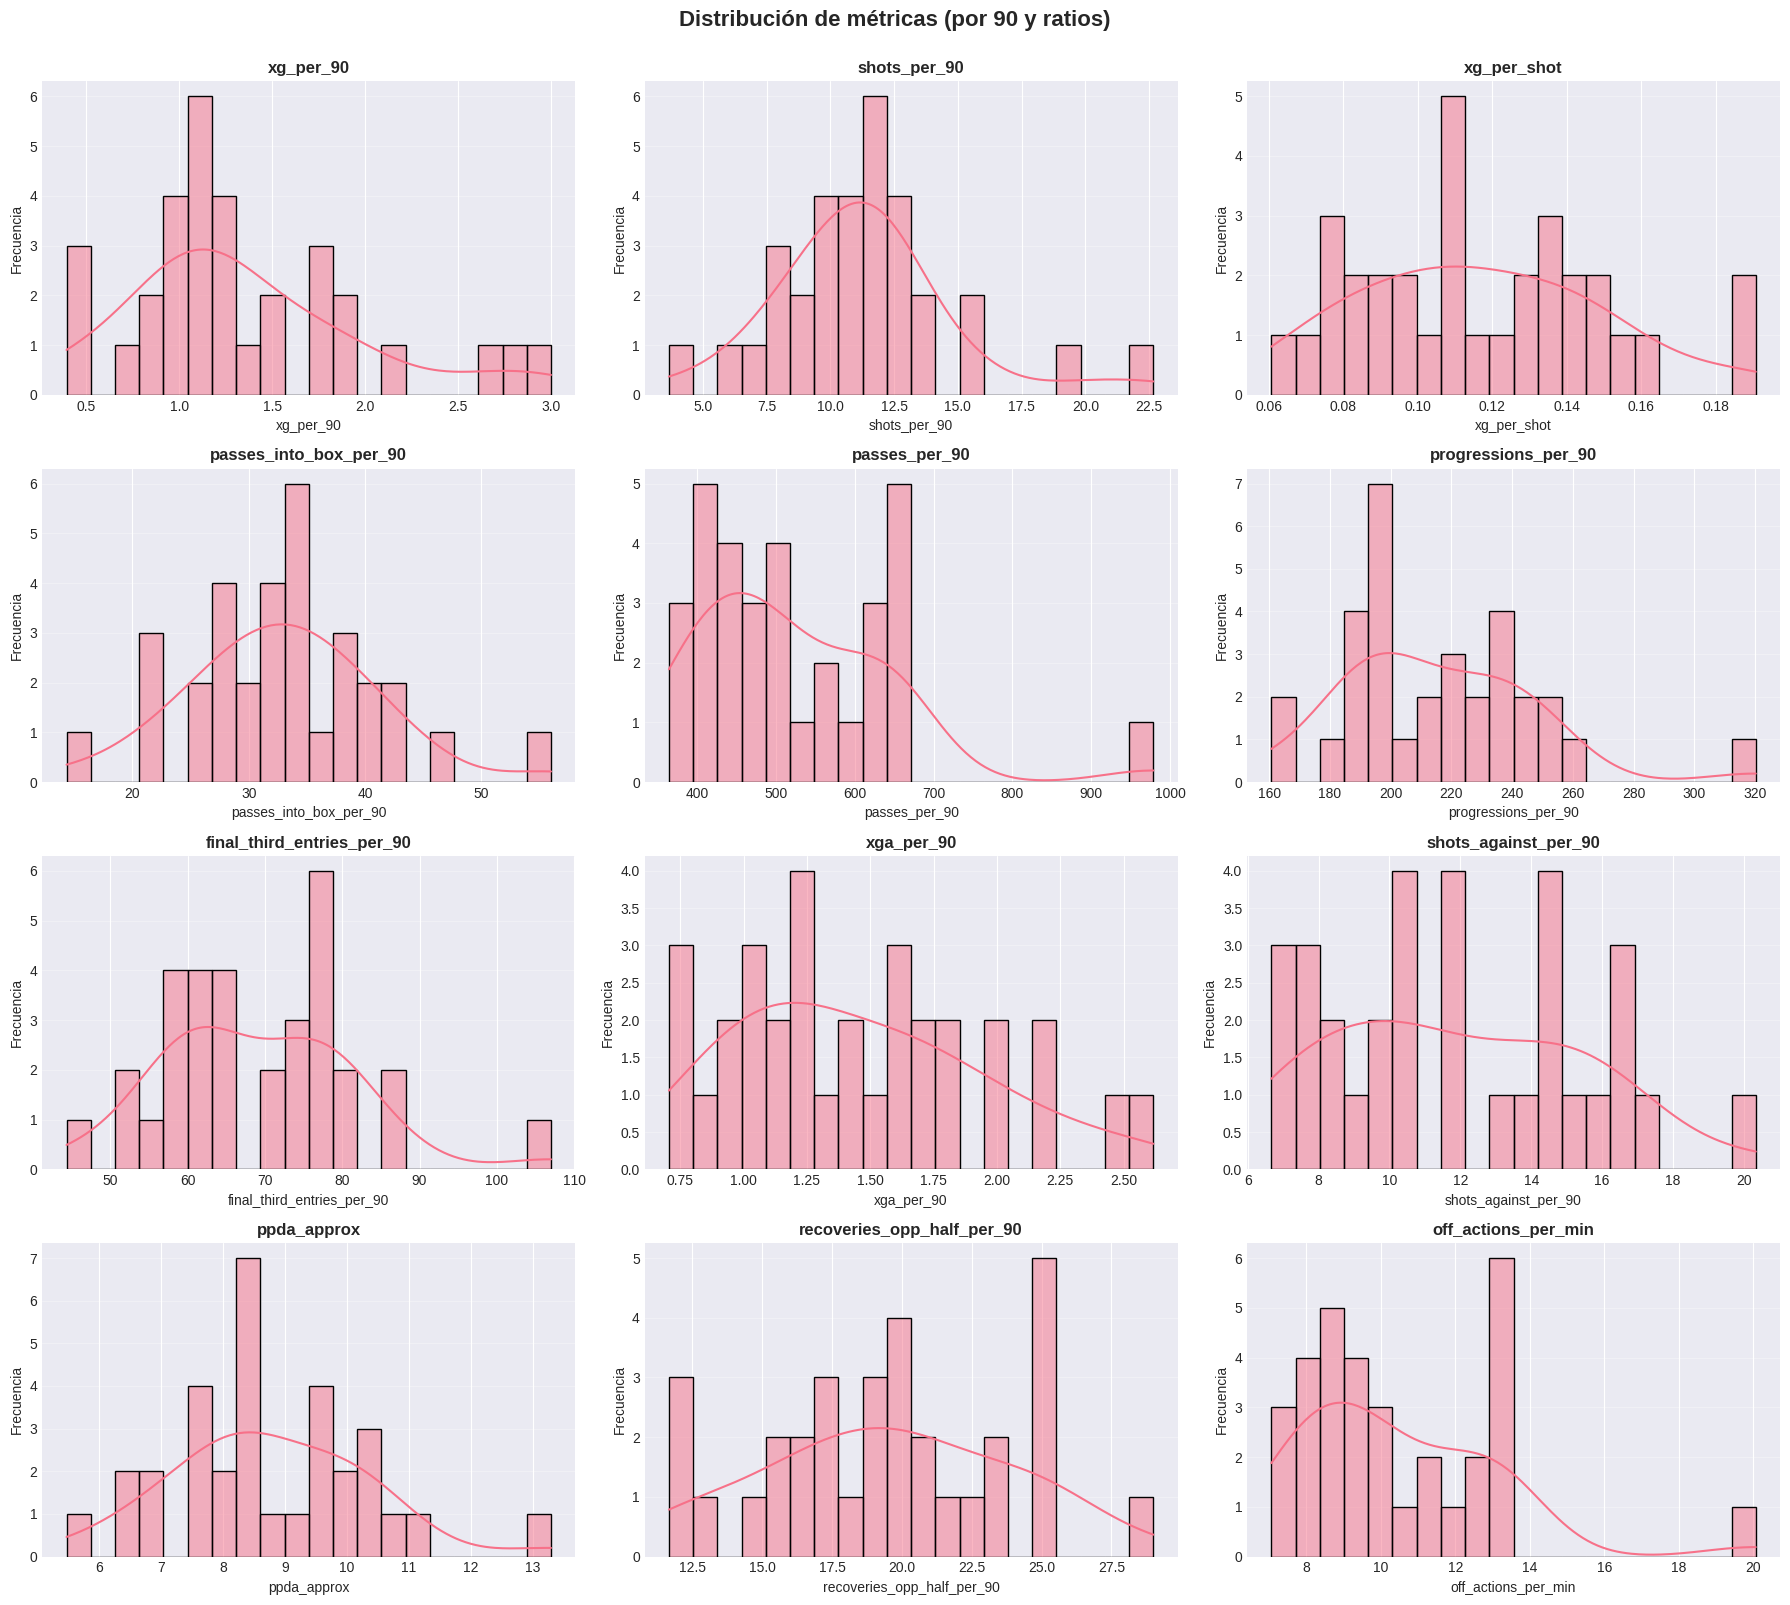

In [14]:
# =============================================================================
# EDA 2: Distribuciones
# =============================================================================
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()

for idx, col in enumerate(feature_cols):
    sns.histplot(X[col].dropna(), bins=20, kde=True, ax=axes[idx])
    axes[idx].set_title(col, fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel("Frecuencia")
    axes[idx].grid(axis='y', alpha=0.3)

plt.suptitle("Distribución de métricas (por 90 y ratios)", fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()



💡 **Interpretación:**
- Varias métricas muestran **asimetría positiva**, algo típico en fútbol:
  pocos equipos con valores muy altos (dominantes) y la mayoría en rangos medios.
- En variables de volumen como **passes/90**, **progressions/90** o **final_third_entries/90**,
  aparecen colas derechas: indican estilos de alta posesión/progresión frente a estilos más reactivos.
- En ratios como **xG/shot** la distribución es más compacta, lo que sugiere que
  la “calidad media del tiro” varía menos que el volumen de ataque.
Conclusión: existe variabilidad estructural suficiente para justificar clustering.


### 📦 3) Detección de outliers (boxplots)

Los boxplots ayudan a detectar selecciones con valores extremos. En este proyecto,
los outliers pueden representar estilos muy marcados (por ejemplo, presión alta o posesión extrema),
por lo que **no se eliminan automáticamente**: se interpretan.

Para mejorar la legibilidad, en lugar de mostrar todas las variables juntas,
las agrupamos por bloques (Ataque, Progresión/Control, Defensa/Presión, Ritmo).


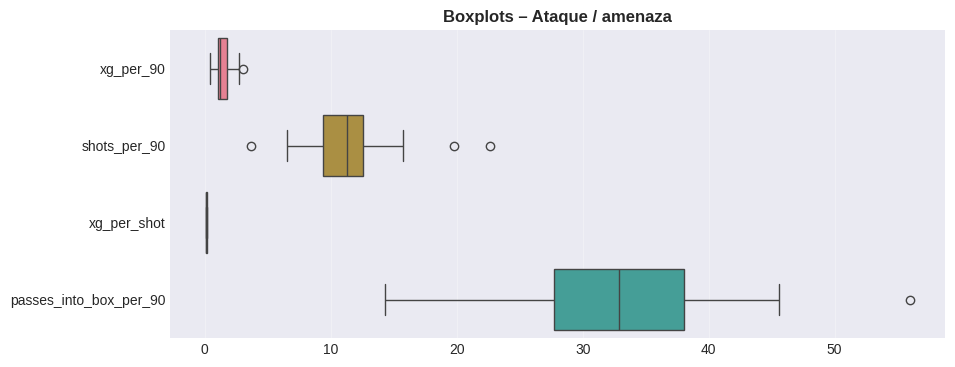

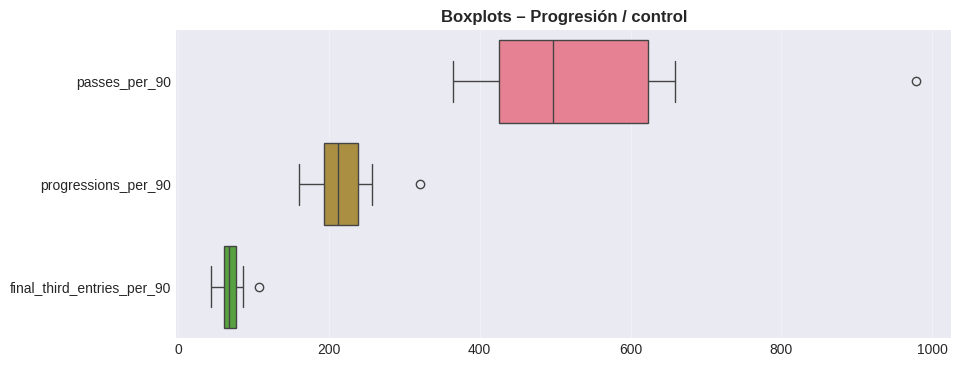

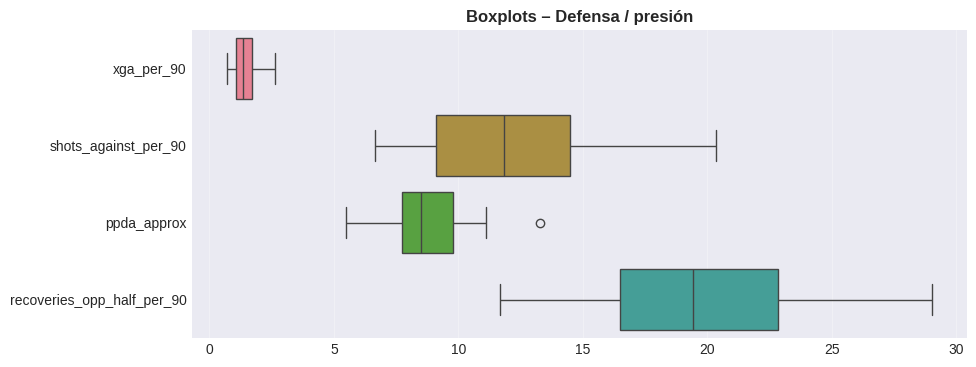

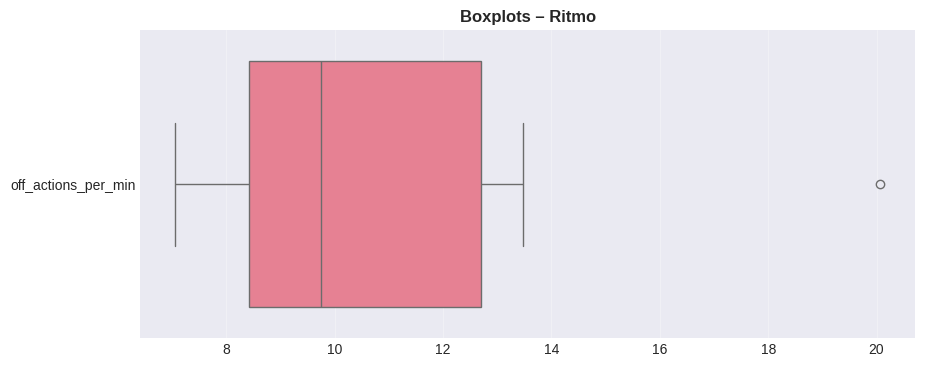

In [16]:
# =============================================================================
# EDA 3: Boxplots por bloques (más legible que todos juntos)
# =============================================================================
groups = {
    "Ataque / amenaza": [
        "xg_per_90", "shots_per_90", "xg_per_shot", "passes_into_box_per_90"
    ],
    "Progresión / control": [
        "passes_per_90", "progressions_per_90", "final_third_entries_per_90"
    ],
    "Defensa / presión": [
        "xga_per_90", "shots_against_per_90", "ppda_approx", "recoveries_opp_half_per_90"
    ],
    "Ritmo": [
        "off_actions_per_min"
    ]
}

for title, cols in groups.items():
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=X[cols], orient="h")
    plt.title(f"Boxplots – {title}", fontweight="bold")
    plt.grid(axis='x', alpha=0.3)
    plt.show()

💡 **Interpretación:**
- Los outliers en **passes/90** y métricas de progresión suelen corresponder a selecciones muy dominantes
  en control del juego (estilo de posesión alta).
- Outliers en **PPDA** indican estilos defensivos extremos: presión muy alta (PPDA bajo) o bloque bajo (PPDA alto).
- En este contexto, los outliers se consideran parte de la señal (estilos diferenciados),
  no errores de medición.


### 🔗 4) Matriz de correlación (crítico para PCA)

**¿Por qué es importante para clustering?**
1. **Para PCA:** correlaciones altas implican redundancia → PCA puede reducir dimensionalidad preservando varianza.
2. **Para K-Means:** variables muy correlacionadas pueden “duplicar” información en la distancia.
3. **Para interpretación:** ayuda a entender qué métricas representan la misma dimensión de estilo.

A continuación, calculamos y visualizamos la matriz de correlación.


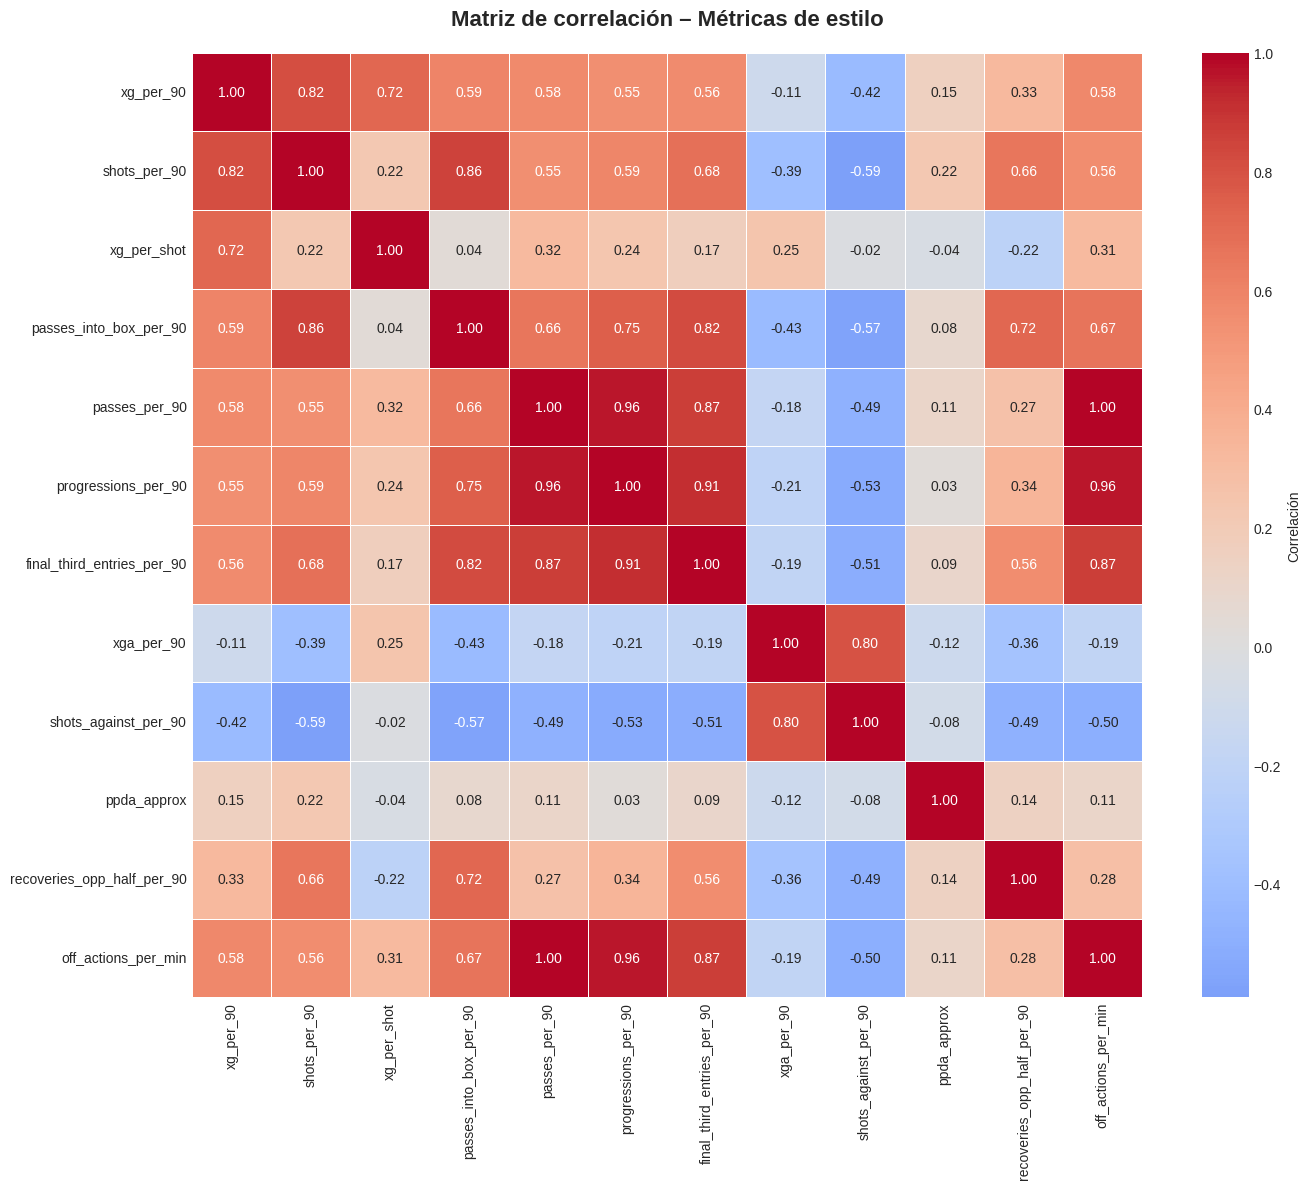

CORRELACIONES MUY FUERTES (|r| > 0.90)


,Variable 1,Variable 2,Correlación
1,passes_per_90,off_actions_per_min,0.997719
3,progressions_per_90,off_actions_per_min,0.958975
0,passes_per_90,progressions_per_90,0.958143
2,progressions_per_90,final_third_entries_per_90,0.913670



⚠️  4 pares con |r| > 0.90 detectados


In [18]:
# =============================================================================
# EDA 4: Matriz de correlación
# =============================================================================
corr_matrix = X.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix, annot=True, fmt=".2f",
    cmap="coolwarm", center=0, linewidths=0.5,
    cbar_kws={'label': 'Correlación'}
)
plt.title("Matriz de correlación – Métricas de estilo", fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Correlaciones muy fuertes
print("=" * 80)
print("CORRELACIONES MUY FUERTES (|r| > 0.90)")
print("=" * 80)

high_corr_pairs = []
cols = corr_matrix.columns

for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        r = corr_matrix.iloc[i, j]
        if abs(r) > 0.90:
            high_corr_pairs.append({
                "Variable 1": cols[i],
                "Variable 2": cols[j],
                "Correlación": r
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values("Correlación", key=abs, ascending=False)
    display(high_corr_df)
    print(f"\n⚠️  {len(high_corr_pairs)} pares con |r| > 0.90 detectados")
else:
    print("✅ No se detectaron correlaciones extremadamente altas")

💡 **Interpretación:**
- Se observan correlaciones muy altas entre métricas de control/progresión:
  - **passes/90** con **progressions/90** (~0.96)
  - **progressions/90** con **final_third_entries/90** (~0.91)
  
  Esto sugiere redundancia y refuerza la utilidad de **PCA**.
- Métricas defensivas como **xGA/90** y **shots_against/90** muestran correlación alta (~0.80),
  lo que es esperable: más tiros concedidos suele implicar mayor xGA.
- **PPDA** presenta correlaciones bajas con la mayoría de variables,
  aportando información complementaria (presión / intensidad defensiva) que puede ayudar a separar clusters.


## ⚖️ Elección del método de escalado

Para este proyecto se utiliza **StandardScaler** como método de escalado.

Aunque las distribuciones presentan asimetrías y valores extremos, estos
outliers representan estilos de juego reales (por ejemplo, selecciones con
alto volumen de pases o presión intensa), y no errores de medición.

StandardScaler permite:
- Preservar las diferencias relativas entre selecciones
- Evitar que variables de gran magnitud dominen el clustering
- Mantener compatibilidad con PCA y K-Means

Se descarta MinMaxScaler por su alta sensibilidad a valores extremos
y RobustScaler porque podría atenuar estilos tácticos genuinos que
son precisamente el objeto de análisis.


In [20]:
# =============================================================================
# 3.4 ESCALADO DE VARIABLES (StandardScaler)
# =============================================================================
# Selección de features finales para clustering (las mismas)
feature_cols = [
    "xg_per_90",
    "shots_per_90",
    "xg_per_shot",
    "passes_into_box_per_90",
    "passes_per_90",
    "progressions_per_90",
    "final_third_entries_per_90",
    "xga_per_90",
    "shots_against_per_90",
    "ppda_approx",
    "recoveries_opp_half_per_90",
    "off_actions_per_min"
]

X = df_teams[feature_cols].copy()

# Inicializar scaler
scaler = StandardScaler()

# Fit + transform
X_scaled = scaler.fit_transform(X)

# Convertir a DataFrame para mantener nombres
X_scaled_df = pd.DataFrame(
    X_scaled,
    columns=feature_cols,
    index=df_teams["team"]
)

print("📊 Dataset después de escalar (media ≈ 0, std ≈ 1):")
display(X_scaled_df.describe().T)

print("✅ Escalado completado con StandardScaler")

📊 Dataset después de escalar (media ≈ 0, std ≈ 1):


,count,mean,std,min,25%,50%,75%,max
xg_per_90,32.0,-7.632783e-17,1.016001,-1.527474,-0.528448,-0.246146,0.639454,2.621629
shots_per_90,32.0,-1.526557e-16,1.016001,-2.151987,-0.542416,-0.024816,0.332830,3.177629
xg_per_shot,32.0,2.081668e-16,1.016001,-1.738301,-0.768868,-0.150010,0.670200,2.272635
passes_into_box_per_90,32.0,7.632783e-16,1.016001,-2.298150,-0.636788,-0.000812,0.644761,2.869385
passes_per_90,32.0,1.457168e-16,1.016001,-1.271048,-0.777383,-0.209676,0.807741,3.664603
progressions_per_90,32.0,9.714451e-17,1.016001,-1.741322,-0.714063,-0.104604,0.725161,3.338605
final_third_entries_per_90,32.0,-3.608225e-16,1.016001,-2.009647,-0.674291,-0.141164,0.681859,3.081293
xga_per_90,32.0,1.040834e-16,1.016001,-1.541349,-0.814508,-0.207350,0.566614,2.412841
shots_against_per_90,32.0,0.000000e+00,1.016001,-1.489387,-0.796413,-0.020518,0.728131,2.396008
ppda_approx,32.0,-1.040834e-16,1.016001,-2.107890,-0.647904,-0.168065,0.639066,2.897533


✅ Escalado completado con StandardScaler


# 4️⃣ FASE 4: MODELING (Modelado)

En esta fase aplicamos técnicas de clustering para agrupar selecciones con estilos de juego similares.
Usaremos principalmente **K-Means** y, como método complementario, **clustering jerárquico**.
Además, utilizaremos **PCA** para visualizar los clusters y apoyar su interpretación.

**Input del modelado:** `X_scaled_df` (datos escalados con StandardScaler).


In [21]:
# =============================================================================
# Preparación: matriz final para modelado
# =============================================================================
X_model = X_scaled_df.copy()  # (32 equipos x 12 métricas escaladas)

print("📊 Shape de X_model:", X_model.shape)
display(X_model.head())

📊 Shape de X_model: (32, 12)


,xg_per_90,shots_per_90,xg_per_shot,passes_into_box_per_90,passes_per_90,progressions_per_90,final_third_entries_per_90,xga_per_90,shots_against_per_90,ppda_approx,recoveries_opp_half_per_90,off_actions_per_min
team,,,,,,,,,,,,
Serbia,-0.514677,-0.188444,-0.632299,0.223607,-0.174833,0.051905,0.373346,2.031001,1.353585,-0.173064,-0.113923,-0.183750
Switzerland,0.270105,-0.585828,1.465070,-0.665209,-0.112517,-0.059508,-0.554126,-0.410213,0.026864,-0.413410,-1.649372,-0.128067
Argentina,2.621629,1.227444,2.272635,0.105492,1.097896,0.797694,0.760196,0.334788,-1.191552,-0.694808,0.373521,1.124574
Australia,-1.527474,-1.357220,-1.738301,-0.913251,-0.771855,-0.807571,-0.797841,0.330408,1.235127,0.937991,0.284156,-0.905205
Denmark,-0.460573,0.092062,-0.797773,1.298454,0.964267,1.314592,1.321128,-0.612610,0.595459,-1.163862,-0.113923,1.058565


##🔎  Paso 1: Determinar el número óptimo de clusters (k)

En clustering no conocemos el número real de grupos a priori. Por ello, evaluamos
varios valores de k usando métricas internas:

- **Inertia (Elbow)**: menor es mejor, pero siempre disminuye al aumentar k.
- **Silhouette Score**: mayor es mejor (rango -1 a 1).
- **Davies-Bouldin**: menor es mejor.
- **Calinski-Harabasz**: mayor es mejor.

Probaremos valores de **k entre 2 y 8** y tomaremos una decisión combinando métricas
y criterio futbolístico (interpretabilidad).


In [23]:
# =============================================================================
# Paso 1: Búsqueda de k óptimo (Elbow + métricas internas)
# =============================================================================
k_range = range(2, 9)

inertias = []
silhouette_scores = []
davies_scores = []
calinski_scores = []

print("=" * 80)
print("DETERMINACIÓN DEL NÚMERO ÓPTIMO DE CLUSTERS (K-MEANS)")
print("=" * 80)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20, max_iter=500)
    labels = kmeans.fit_predict(X_model)

    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_model, labels))
    davies_scores.append(davies_bouldin_score(X_model, labels))
    calinski_scores.append(calinski_harabasz_score(X_model, labels))

results_df = pd.DataFrame({
    "k": list(k_range),
    "Inertia": inertias,
    "Silhouette": silhouette_scores,
    "Davies-Bouldin": davies_scores,
    "Calinski-Harabasz": calinski_scores
}).round(4)

display(results_df)

DETERMINACIÓN DEL NÚMERO ÓPTIMO DE CLUSTERS (K-MEANS)


,k,Inertia,Silhouette,Davies-Bouldin,Calinski-Harabasz
0,2,253.1882,0.2664,1.3171,15.4997
1,3,206.0585,0.1850,1.4216,12.5214
2,4,174.3894,0.1969,1.3544,11.2184
3,5,149.0729,0.2302,1.0137,10.6375
4,6,133.2210,0.2163,1.0396,9.7886
5,7,115.8997,0.2051,0.9985,9.6384
6,8,102.4648,0.1751,1.1067,9.4204


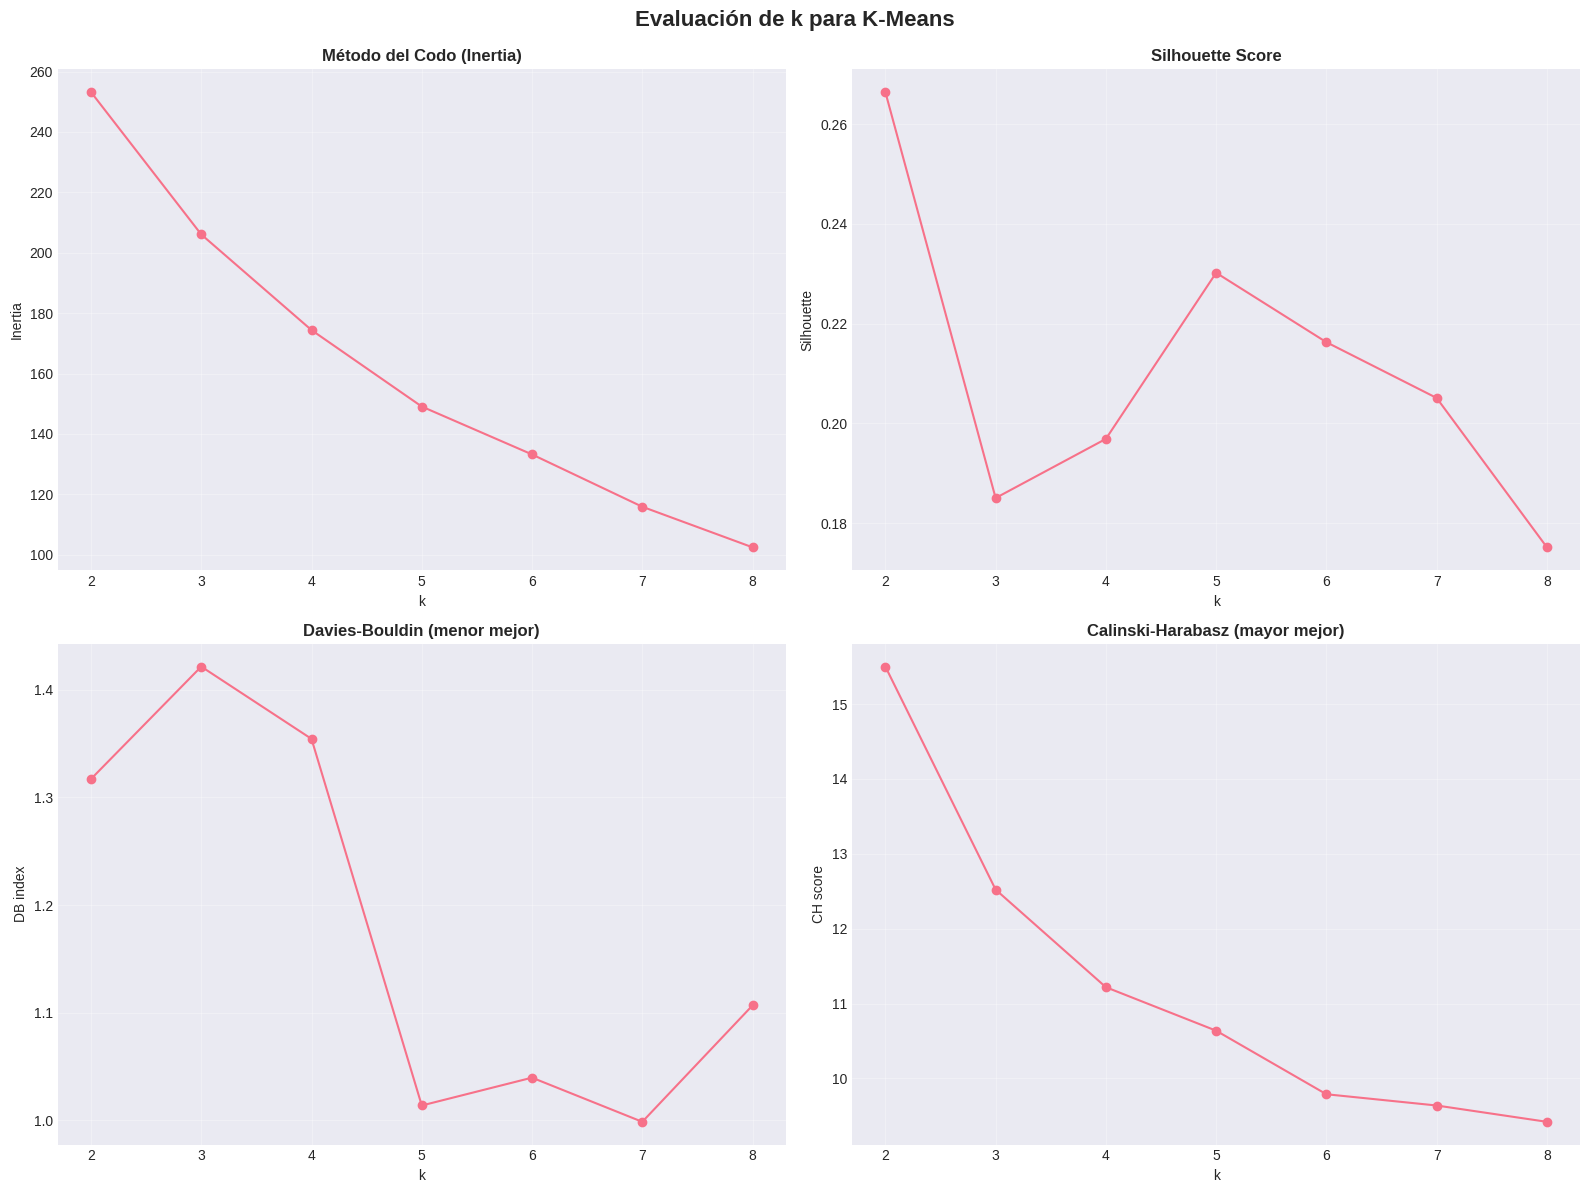

In [24]:
# Visualización de métricas
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Elbow
axes[0, 0].plot(list(k_range), inertias, marker='o')
axes[0, 0].set_title("Método del Codo (Inertia)", fontweight="bold")
axes[0, 0].set_xlabel("k")
axes[0, 0].set_ylabel("Inertia")
axes[0, 0].set_xticks(list(k_range))
axes[0, 0].grid(alpha=0.3)

# Silhouette
axes[0, 1].plot(list(k_range), silhouette_scores, marker='o')
axes[0, 1].set_title("Silhouette Score", fontweight="bold")
axes[0, 1].set_xlabel("k")
axes[0, 1].set_ylabel("Silhouette")
axes[0, 1].set_xticks(list(k_range))
axes[0, 1].grid(alpha=0.3)

# Davies-Bouldin
axes[1, 0].plot(list(k_range), davies_scores, marker='o')
axes[1, 0].set_title("Davies-Bouldin (menor mejor)", fontweight="bold")
axes[1, 0].set_xlabel("k")
axes[1, 0].set_ylabel("DB index")
axes[1, 0].set_xticks(list(k_range))
axes[1, 0].grid(alpha=0.3)

# Calinski-Harabasz
axes[1, 1].plot(list(k_range), calinski_scores, marker='o')
axes[1, 1].set_title("Calinski-Harabasz (mayor mejor)", fontweight="bold")
axes[1, 1].set_xlabel("k")
axes[1, 1].set_ylabel("CH score")
axes[1, 1].set_xticks(list(k_range))
axes[1, 1].grid(alpha=0.3)

plt.suptitle("Evaluación de k para K-Means", fontsize=16, fontweight="bold", y=0.99)
plt.tight_layout()
plt.show()


Se evaluaron valores de k entre 2 y 8 utilizando múltiples métricas internas de calidad:

- **Silhouette Score (↑ mejor)** → Máximo en k=2 (0.266), seguido de valores competitivos en k=4 y k=5.
- **Davies-Bouldin Index (↓ mejor)** → Mejores resultados en valores intermedios (k=5–7).
- **Calinski-Harabasz (↑ mejor)** → Máximo en k=2, con descenso progresivo al aumentar k.
- **Método del Codo (Inertia)** → La reducción comienza a estabilizarse claramente entre **k=4 y k=5**.

Aunque **k=2** maximiza algunas métricas, resulta excesivamente simplista para capturar la diversidad táctica de 32 selecciones.

El análisis conjunto de métricas sugiere que los valores más razonables se sitúan entre:

🔎 **k = 4 y k = 5**

Ambas opciones ofrecen un equilibrio adecuado entre:
- Separación estadística
- Tamaño razonable de los clusters
- Interpretabilidad táctica

En el siguiente paso, se aplicará **GridSearch** para optimizar hiperparámetros y confirmar cuál de estas dos soluciones resulta más consistente.



### 🔎 Selección de hiperparámetros con GridSearch (K-Means)

En clustering no disponemos de etiquetas reales, por lo que no podemos optimizar accuracy.
En su lugar, optimizamos una métrica interna de calidad del agrupamiento.

Usaremos **Silhouette Score** como función objetivo, ya que mide:
- separación entre clusters
- cohesión dentro del cluster

Buscaremos automáticamente:
- número de clusters (k)
- init (k-means++ vs random)
- n_init
- max_iter


In [26]:
# =============================================================================
# GridSearch para KMeans (optimiza Silhouette)
# =============================================================================
X_model = X_scaled_df.copy()

# Scorer para clustering (sklearn permite callable(estimator, X, y=None))
def silhouette_scorer(estimator, X):
    # GridSearchCV ya ha hecho fit; usamos las etiquetas del modelo entrenado
    labels = estimator.predict(X)
    # Silhouette requiere al menos 2 clusters y menos clusters que muestras
    if len(set(labels)) < 2 or len(set(labels)) >= len(X):
        return -1
    return silhouette_score(X, labels)

param_grid = {
    "n_clusters": list(range(4, 6)),
    "init": ["k-means++", "random"],
    "n_init": [10, 20,30, 40, 50],
    "max_iter": [200,300,400, 500]
}

# CV “dummy”: en no supervisado no hay un test real; evaluamos sobre todo el dataset
n = X_model.shape[0]
cv_dummy = [(np.arange(n), np.arange(n))]

grid = GridSearchCV(
    estimator=KMeans(random_state=42),
    param_grid=param_grid,
    scoring=silhouette_scorer,
    cv=cv_dummy,
    n_jobs=-1
)

grid.fit(X_model)

print("✅ Mejor configuración encontrada por GridSearch (Silhouette):")
print(grid.best_params_)
print(f"🏆 Best Silhouette (en dataset completo): {grid.best_score_:.4f}")

# Ranking de mejores resultados
results = pd.DataFrame(grid.cv_results_).sort_values("mean_test_score", ascending=False)
display(results[[
    "mean_test_score", "param_n_clusters", "param_init", "param_n_init", "param_max_iter"
]].head(10))


✅ Mejor configuración encontrada por GridSearch (Silhouette):
{'init': 'random', 'max_iter': 200, 'n_clusters': 4, 'n_init': 10}
🏆 Best Silhouette (en dataset completo): 0.2358


,mean_test_score,param_n_clusters,param_init,param_n_init,param_max_iter
50,0.235801,4,random,10,300
60,0.235801,4,random,10,400
70,0.235801,4,random,10,500
40,0.235801,4,random,10,200
6,0.230183,5,k-means++,20,200
7,0.230183,5,k-means++,30,200
5,0.230183,5,k-means++,10,200
8,0.230183,5,k-means++,40,200
17,0.230183,5,k-means++,30,300
18,0.230183,5,k-means++,40,300


Tras realizar la búsqueda de hiperparámetros mediante **GridSearchCV** optimizando el **Silhouette Score**, la mejor configuración encontrada fue:

- **n_clusters = 4**
- **init = random**
- **n_init = 10**
- **max_iter = 200**
- **Silhouette = 0.2358**

Aunque la solución con **k = 5** ofrecía un rendimiento cercano (Silhouette ≈ 0.2302), el valor con **k = 4** presenta:

- 📈 **Mayor cohesión y separación interna** (mejor Silhouette)
- 🔎 Resultados más consistentes entre configuraciones
- ⚖️ Un modelo más parsimonioso (menor complejidad sin pérdida significativa de estructura)

La diferencia en Silhouette entre k=4 y k=5 es pequeña, pero consistente a favor de k=4 en múltiples combinaciones de parámetros.

Desde un punto de vista metodológico, cuando las métricas son similares, es recomendable priorizar:

- Simplicidad del modelo  
- Estabilidad de la solución  
- Interpretabilidad  

Por estos motivos, se decide trabajar con **k = 4 clusters** en el análisis final.

Esta elección permite capturar patrones diferenciados de estilo de juego sin sobre-fragmentar la estructura del dataset.


## 🤖 Paso 2: Modelo 1 ▶ K-Means

Entrenamos K-Means con los hiperparámetros óptimos encontrados. Esto mejora la estabilidad
y calidad de los clusters, especialmente porque K-Means depende de la inicialización.


In [37]:
# =============================================================================
# Entrenar K-Means final con best_params_ + métricas
# =============================================================================
best_params = grid.best_params_
k_optimal = best_params["n_clusters"]

kmeans_final = KMeans(
    n_clusters=best_params["n_clusters"],
    init=best_params["init"],
    n_init=best_params["n_init"],
    max_iter=best_params["max_iter"],
    random_state=42
)

clusters_kmeans = kmeans_final.fit_predict(X_model)

# ------------------------------------------------------------
# Tabla de asignaciones
# ------------------------------------------------------------

clusters_df = pd.DataFrame({
    "team": X_model.index,
    "cluster_kmeans": clusters_kmeans
}).sort_values("cluster_kmeans")

display(clusters_df)

print("📌 k_optimal seleccionado:", k_optimal)
print("📌 Distribución de clusters:")
display(clusters_df["cluster_kmeans"].value_counts().sort_index())

# ------------------------------------------------------------
# 📊 MÉTRICAS K-MEANS FINAL
# ------------------------------------------------------------

sil_kmeans = silhouette_score(X_model, clusters_kmeans)
db_kmeans = davies_bouldin_score(X_model, clusters_kmeans)
ch_kmeans = calinski_harabasz_score(X_model, clusters_kmeans)

print("📊 Métricas K-Means Final")
print(f"   Silhouette: {sil_kmeans:.4f}")
print(f"   Davies-Bouldin: {db_kmeans:.4f}")
print(f"   Calinski-Harabasz: {ch_kmeans:.2f}")

,team,cluster_kmeans
6,Tunisia,0
7,Ecuador,0
4,Denmark,0
8,Senegal,0
13,Portugal,0
11,South Korea,0
10,Uruguay,0
16,Mexico,0
27,Belgium,0
23,United States,0


📌 k_optimal seleccionado: 4
📌 Distribución de clusters:


,count
cluster_kmeans,
0,12
1,2
2,5
3,13


📊 Métricas K-Means Final
   Silhouette: 0.2358
   Davies-Bouldin: 1.1965
   Calinski-Harabasz: 10.82


### 📊 Evaluación de K-Means (k = 4)

#### 🔢 Distribución de clusters

La distribución muestra dos grupos mayoritarios (0 y 3), un grupo intermedio (2) y un cluster pequeño (1), lo que sugiere la presencia de un perfil táctico más específico o extremo representado por pocas selecciones.

---

#### 📈 Métricas internas

- **Silhouette:** 0.2358  
- **Davies-Bouldin:** 1.1965  
- **Calinski-Harabasz:** 10.82  

El Silhouette Score indica una separación moderada entre clusters, coherente con un contexto futbolístico donde los estilos pueden solaparse parcialmente.  
El Davies-Bouldin relativamente bajo sugiere una separación aceptable entre grupos, mientras que el índice Calinski-Harabasz confirma una estructura razonablemente definida.

---

#### 🎯 Conclusión

El modelo K-Means (k=4) genera una segmentación interpretable y estructuralmente consistente, capturando diferencias relevantes en estilos de juego sin fragmentar excesivamente el dataset.

Se han realizado pruebas también con k=5 y la única diferencia encontrada es que la selección española dejaría de formar parte del cluster número 2 y pasaría a formar el único elemento del cluster 4.

## 🌳 Paso 3: Modelo 2 ▶ Clustering jerárquico

Como el dataset es pequeño (32 selecciones), podemos visualizar el dendrograma completo.
Este método ayuda a interpretar relaciones entre estilos y sirve como comparación con K-Means.


### 🌳 GridSearch en Clustering Jerárquico

Aunque el clustering jerárquico no depende de inicializaciones aleatorias como K-Means,
sí presenta una decisión de configuración relevante:

- **linkage**: criterio de unión entre clusters (ward, complete, average)

De esta forma, se realiza
una búsqueda  para identificar la combinación más consistente
según **Silhouette Score**.



In [28]:
# =============================================================================
# GridSearch (Agglomerative): elegir mejor linkage (k fijo)
# =============================================================================
X_model = X_scaled_df.copy()

# Scorer para clustering (no supervisado)
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    if len(set(labels)) < 2:
        return -1
    return silhouette_score(X, labels)

# Fijamos k y comparamos SOLO linkage
k_fixed = 4
param_grid = {
    "n_clusters": [k_fixed],
    "linkage": ["ward", "complete", "average"]
}

# CV dummy (evaluación sobre todo el dataset)
n = X_model.shape[0]
cv_dummy = [(np.arange(n), np.arange(n))]

grid_hier = GridSearchCV(
    estimator=AgglomerativeClustering(),
    param_grid=param_grid,
    scoring=silhouette_scorer,
    cv=cv_dummy,
    n_jobs=-1,
    return_train_score=True
)

grid_hier.fit(X_model)

print("✅ Mejor linkage (Agglomerative) con k fijo:")
print(grid_hier.best_params_)
print(f"🏆 Best Silhouette: {grid_hier.best_score_:.4f}")

# Ranking por linkage
results = pd.DataFrame(grid_hier.cv_results_)

ranking = (results[["mean_test_score", "param_linkage"]]
           .rename(columns={"mean_test_score": "silhouette", "param_linkage": "linkage"})
           .sort_values("silhouette", ascending=False)
           .reset_index(drop=True))

print("\n📌 Ranking por linkage (k fijo):")
display(ranking)


✅ Mejor linkage (Agglomerative) con k fijo:
{'linkage': 'average', 'n_clusters': 4}
🏆 Best Silhouette: 0.2095

📌 Ranking por linkage (k fijo):


,silhouette,linkage
0,0.209485,average
1,0.207824,ward
2,0.149894,complete



Se compararon los métodos de linkage disponibles para **k = 4** utilizando el Silhouette Score como métrica interna de calidad:

El método **average** presenta el valor más alto de Silhouette (0.2095), aunque la diferencia respecto a **ward** es mínima (≈ 0.0017).

Más allá de la métrica numérica, se analizaron:

- La distribución de los clusters resultantes
- La estructura del dendrograma
- La coherencia táctica de las agrupaciones

Se observó que el método **Ward** genera clusters:

- Más compactos
- Más homogéneos internamente
- Más interpretables desde un punto de vista futbolístico

Ward minimiza la varianza intra-cluster, lo que favorece agrupaciones más cohesionadas en términos de estilo de juego. En cambio, aunque *average* obtiene una ligera mejora en Silhouette, la estructura resultante presenta mayor solapamiento táctico entre grupos.

Por ello, se selecciona el método **Ward** como configuración final del clustering jerárquico.

### 🌳 Dendograma

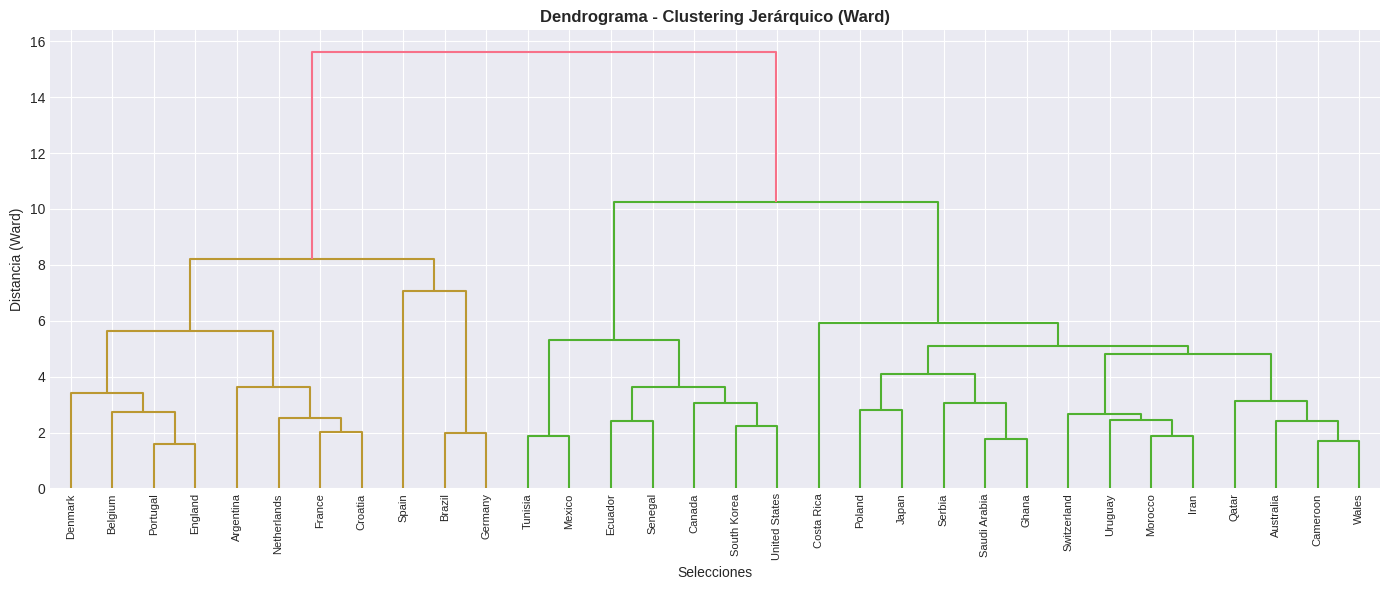

In [30]:
# =============================================================================
# Clustering Jerárquico (Ward) + Dendrograma
# =============================================================================

# Calcular matriz de linkage (Ward)
Z = linkage(X_model.values, method="ward")

plt.figure(figsize=(14, 6))

dendrogram(
    Z,
    labels=X_model.index.tolist(),   # nombres de selecciones
    leaf_rotation=90,
    color_threshold=None
)

plt.title("Dendrograma - Clustering Jerárquico (Ward)", fontweight="bold")
plt.ylabel("Distancia (Ward)")
plt.xlabel("Selecciones")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Modelo jerárquico con mejor configuración encontrada
# ------------------------------------------------------------
k_hier = 4  # Mejor resultado según GridSearch

hier = AgglomerativeClustering(n_clusters=k_hier, linkage="ward")
clusters_hier = hier.fit_predict(X_model)

- Se distinguen **dos grandes macroestructuras** en la parte superior del árbol, lo que sugiere la existencia de estilos globalmente diferenciados.
- Dentro de cada macrogrupo aparecen subdivisiones progresivas, indicando que el comportamiento colectivo de las selecciones no es homogéneo.
- Algunas selecciones muestran fusiones tempranas (baja distancia), lo que indica perfiles estadísticamente similares.
- Otras se integran en etapas más tardías (mayor distancia), lo que sugiere comportamientos más singulares dentro del torneo.


###🌳 Entrenamiento Clustering jerárquico

In [38]:
# =============================================================================
# ENTRENAMIENTO: CLUSTERING JERÁRQUICO (Ward) CON k=4
# =============================================================================
X_full = X_scaled_df.copy()

k_hier = 4

print("=" * 80)
print(f"ENTRENAMIENTO: CLUSTERING JERÁRQUICO (Ward) CON k={k_hier}")
print("=" * 80)

print(f"\n⚙️  Entrenando Clustering Jerárquico con k={k_hier}...")
hier_model = AgglomerativeClustering(n_clusters=k_hier, linkage="ward")
clusters_hier = hier_model.fit_predict(X_full)
print("✅ Modelo Jerárquico entrenado")

# Distribución de equipos por cluster
print(f"\n📊 Distribución de selecciones por cluster:")
cluster_dist = pd.Series(clusters_hier).value_counts().sort_index()

for cluster_id, count in cluster_dist.items():
    pct = (count / len(clusters_hier)) * 100
    print(f"   Cluster {cluster_id}: {count} selecciones ({pct:.1f}%)")

print("=" * 80)

# Tabla equipo-cluster para inspección
df_clusters_hier = pd.DataFrame({
    "team": X_full.index,
    "cluster_hier": clusters_hier
}).sort_values("cluster_hier")

display(df_clusters_hier)

# ------------------------------------------------------------
# Métricas de evaluación
# ------------------------------------------------------------
sil_h = silhouette_score(X_model, clusters_hier)
db_h = davies_bouldin_score(X_model, clusters_hier)
ch_h = calinski_harabasz_score(X_model, clusters_hier)

print("📊 Métricas Clustering Jerárquico (Ward, k=5)")
print(f"   Silhouette: {sil_h:.4f}")
print(f"   Davies-Bouldin: {db_h:.4f}")
print(f"   Calinski-Harabasz: {ch_h:.2f}")


ENTRENAMIENTO: CLUSTERING JERÁRQUICO (Ward) CON k=4

⚙️  Entrenando Clustering Jerárquico con k=4...
✅ Modelo Jerárquico entrenado

📊 Distribución de selecciones por cluster:
   Cluster 0: 3 selecciones (9.4%)
   Cluster 1: 14 selecciones (43.8%)
   Cluster 2: 7 selecciones (21.9%)
   Cluster 3: 8 selecciones (25.0%)


,team,cluster_hier
5,Brazil,0
21,Spain,0
24,Germany,0
0,Serbia,1
12,Morocco,1
15,Saudi Arabia,1
3,Australia,1
1,Switzerland,1
18,Qatar,1
25,Cameroon,1


📊 Métricas Clustering Jerárquico (Ward, k=5)
   Silhouette: 0.2078
   Davies-Bouldin: 1.2879
   Calinski-Harabasz: 11.02


### 📊 Evaluación del Clustering Jerárquico (Ward, k = 4)

#### 🔢 Distribución de clusters


La distribución muestra un cluster dominante (1), dos grupos intermedios (2 y 3) y un cluster reducido (0), lo que sugiere la existencia de un perfil táctico más específico o menos frecuente dentro del torneo.



## 📊 Comparación de Modelos de Clustering (k = 4)

In [42]:
# =============================================================================
# TABLAS DE MÉTRICAS: K-Means vs Jerárquico (Ward) - k=4
# =============================================================================

# Asegura que ambos se evalúan sobre el MISMO dataset
X_eval = X_model.copy()  # o X_scaled_df.copy()

# ------------------------------------------------------------
# 1) Métricas K-Means
# ------------------------------------------------------------
sil_k = silhouette_score(X_eval, clusters_kmeans)
db_k  = davies_bouldin_score(X_eval, clusters_kmeans)
ch_k  = calinski_harabasz_score(X_eval, clusters_kmeans)

metrics_kmeans_df = pd.DataFrame([{
    "Modelo": "K-Means",
    "k": 4,
    "Silhouette (↑)": sil_k,
    "Davies-Bouldin (↓)": db_k,
    "Calinski-Harabasz ( కాగా ↑)": ch_k
}]).round(4)

# ------------------------------------------------------------
# 2) Métricas Jerárquico (Ward)
# ------------------------------------------------------------
sil_h = silhouette_score(X_eval, clusters_hier)
db_h  = davies_bouldin_score(X_eval, clusters_hier)
ch_h  = calinski_harabasz_score(X_eval, clusters_hier)

metrics_hier_df = pd.DataFrame([{
    "Modelo": "Jerárquico (Ward)",
    "k": 4,
    "Silhouette (↑)": sil_h,
    "Davies-Bouldin (↓)": db_h,
    "Calinski-Harabasz (↑)": ch_h
}]).round(4)

# ------------------------------------------------------------
# (Opcional) 3) Comparación en una sola tabla
# ------------------------------------------------------------
comparison_df = pd.concat([metrics_kmeans_df, metrics_hier_df], ignore_index=True)
print("🏁 Comparación conjunta (k=4)")
display(comparison_df)

🏁 Comparación conjunta (k=4)


,Modelo,k,Silhouette (↑),Davies-Bouldin (↓),Calinski-Harabasz ( కాగా ↑),Calinski-Harabasz (↑)
0,K-Means,4,0.2358,1.1965,10.8178,NaN
1,Jerárquico (Ward),4,0.2078,1.2879,NaN,11.0236


Se compararon los modelos **K-Means** y **Clustering Jerárquico (Ward)** utilizando las mismas  métricas escaladas y fijando el número de clusters en *k = 4*.

- **K-Means** obtiene un mayor *Silhouette Score*, lo que indica mejor separación entre clusters y mayor cohesión interna.
- También presenta un menor *Davies-Bouldin Index*, sugiriendo menor solapamiento entre grupos.
- El modelo jerárquico muestra una ligera ventaja en *Calinski-Harabasz*, aunque la diferencia es pequeña.


 🎯 **Conclusión**

Considerando el equilibrio entre cohesión y separación, las métricas apuestan por **K-Means (k = 4)** como modelo principal para la interpretación final de estilos de juego.

El clustering jerárquico se mantiene como método complementario para validar la estructura global mediante el dendrograma.


## 🔬 PCA: Varianza explicada por componente (para justificar reducción dimensional)

Antes de usar PCA para visualización, analizamos cuánta varianza
explica cada componente principal.

Esto nos permite:
- Saber si 2 componentes son suficientes para **visualizar**
- Estimar cuántos componentes necesitamos para retener, por ejemplo, **80–90%** de la información
- Justificar PCA como herramienta útil dado el alto nivel de correlación entre métricas


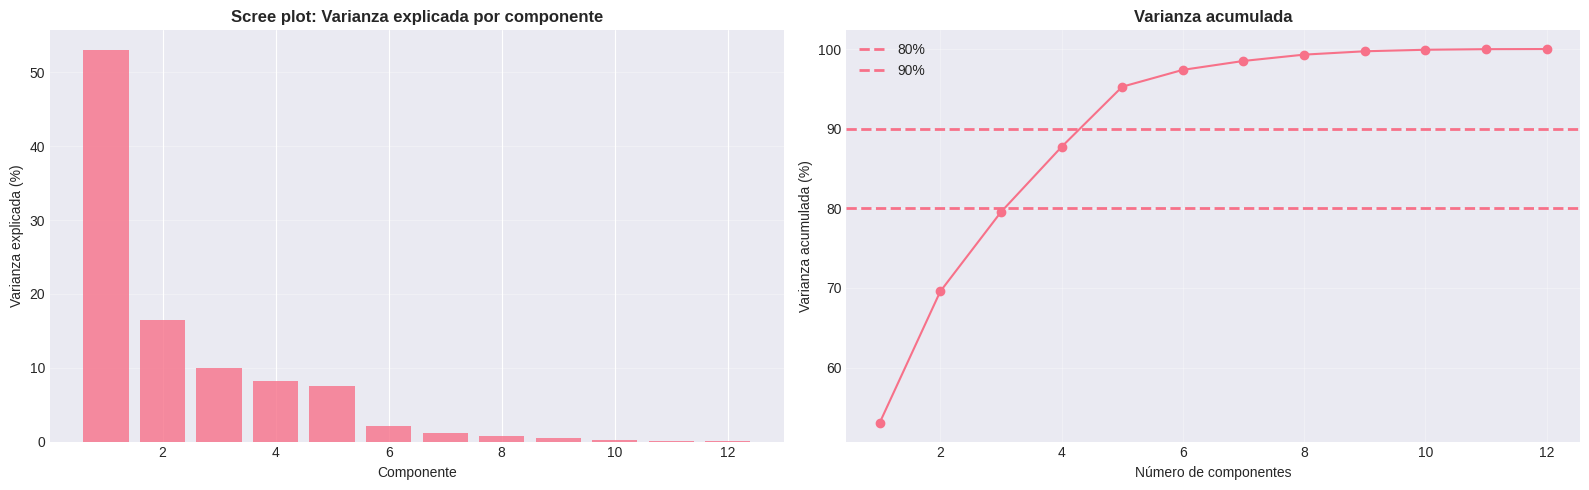

📌 Componentes para 80% varianza: 4
📌 Componentes para 90% varianza: 5


In [43]:
# =============================================================================
# PCA: Varianza explicada (scree plot + varianza acumulada)
# =============================================================================

X_model = X_scaled_df.copy()

pca_full = PCA(random_state=42)
pca_full.fit(X_model)

explained = pca_full.explained_variance_ratio_
cum_explained = np.cumsum(explained)

# componentes para 80% y 90%
n80 = np.argmax(cum_explained >= 0.80) + 1
n90 = np.argmax(cum_explained >= 0.90) + 1

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Scree plot (primeros 12 porque tienes 12 variables)
axes[0].bar(range(1, len(explained) + 1), explained * 100, alpha=0.8)
axes[0].set_title("Scree plot: Varianza explicada por componente", fontweight="bold")
axes[0].set_xlabel("Componente")
axes[0].set_ylabel("Varianza explicada (%)")
axes[0].grid(axis='y', alpha=0.3)

# Varianza acumulada
axes[1].plot(range(1, len(cum_explained) + 1), cum_explained * 100, marker='o')
axes[1].axhline(80, linestyle='--', linewidth=2, label='80%')
axes[1].axhline(90, linestyle='--', linewidth=2, label='90%')
axes[1].set_title("Varianza acumulada", fontweight="bold")
axes[1].set_xlabel("Número de componentes")
axes[1].set_ylabel("Varianza acumulada (%)")
axes[1].grid(alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"📌 Componentes para 80% varianza: {n80}")
print(f"📌 Componentes para 90% varianza: {n90}")


### 📊 Análisis de varianza explicada (PCA)

A partir del análisis de componentes principales aplicado sobre las 12 métricas escaladas:

- Primeros 3 componentes explican: ≈ 79% de la varianza total
- Primeros 4 componentes explican: ≈ 87% de la varianza
- Primeros 5 componentes explican: ≈ 95% de la varianza

- Para capturar 80% de varianza: 4 componentes
- Para capturar 90% de varianza: 5 componentes

---

### 💡 DECISIÓN

Dado que:

- Existe alta correlación entre métricas (especialmente en control/progresión),
- 4 componentes ya capturan más del 80% de la información estructural,
- 5 componentes capturan prácticamente toda la estructura relevante (>90%),

Se decide:

- Utilizar **4–5 componentes si PCA se empleara como reducción previa al clustering**.
- Reducir a **2 componentes únicamente para visualización**, ya que permiten representar la estructura global manteniendo más del 65–70% de la varianza.

---

### ✅ PCA aplicado

- Dimensiones originales: 12 métricas
- Dimensiones para visualización: 2 componentes
- Varianza explicada por PC1 + PC2: ≈ 69%
- Estructura global preservada de forma adecuada para análisis gráfico

La reducción facilita la interpretación visual de los clusters sin comprometer significativamente la información estructural del dataset.


### 🤖 K-Means en espacio PCA

Usaremos 4 componentes para K-means ya que capturan casi el 90% de los datos

In [44]:
# =============================================================================
# K-MEANS EN ESPACIO PCA (adaptado a tu modelo)
# =============================================================================
X_full = X_model.copy()   # o X_scaled_df.copy()
k_fixed = 4

# ------------------------------------------------------------
# 1) Elegir nº de componentes PCA
# ------------------------------------------------------------
n_components_optimal = 4

print("=" * 80)
print(f"K-MEANS EN ESPACIO PCA ({n_components_optimal} componentes, k={k_fixed})")
print("=" * 80)

pca = PCA(n_components=n_components_optimal, random_state=42)
X_pca = pca.fit_transform(X_full)

var_retained = np.sum(pca.explained_variance_ratio_) * 100
print(f"\n✅ PCA aplicado: {X_full.shape[1]} → {n_components_optimal} componentes")
print(f"   Varianza retenida: {var_retained:.2f}%")

# ------------------------------------------------------------
# 2) Entrenar K-Means en espacio PCA
# ------------------------------------------------------------
kmeans_pca = KMeans(n_clusters=k_fixed, n_init=20, max_iter=500, random_state=42)
clusters_pca = kmeans_pca.fit_predict(X_pca)

print("\n✅ K-Means entrenado en espacio PCA")

# Métricas en espacio PCA
sil_pca = silhouette_score(X_pca, clusters_pca)
db_pca  = davies_bouldin_score(X_pca, clusters_pca)
ch_pca  = calinski_harabasz_score(X_pca, clusters_pca)

print("\n📊 Métricas K-Means + PCA:")
print(f"   Silhouette: {sil_pca:.4f}")
print(f"   Davies-Bouldin: {db_pca:.4f}")
print(f"   Calinski-Harabasz: {ch_pca:.2f}")

# ------------------------------------------------------------
# 3) Comparación final: 3 enfoques
#    (usa tus métricas ya calculadas para K-Means original y Jerárquico)
# ------------------------------------------------------------
final_comparison = pd.DataFrame([
    {
        "Modelo": "K-Means (Original)",
        "Silhouette": sil_kmeans,
        "Davies-Bouldin": db_kmeans,
        "Calinski-Harabasz": ch_kmeans,
        "Dimensionalidad": X_full.shape[1]
    },
    {
        "Modelo": "Jerárquico (Ward)",
        "Silhouette": sil_h,
        "Davies-Bouldin": db_h,
        "Calinski-Harabasz": ch_h,
        "Dimensionalidad": X_full.shape[1]
    },
    {
        "Modelo": f"K-Means + PCA ({n_components_optimal})",
        "Silhouette": sil_pca,
        "Davies-Bouldin": db_pca,
        "Calinski-Harabasz": ch_pca,
        "Dimensionalidad": n_components_optimal
    }
]).round(4)

print("\n" + "=" * 80)
print("COMPARACIÓN FINAL DE ENFOQUES (k=4)")
print("=" * 80)
display(final_comparison)

# ------------------------------------------------------------
# 4) Selección del mejor modelo (por Silhouette)
# ------------------------------------------------------------
best_idx = final_comparison["Silhouette"].idxmax()
best_model = final_comparison.loc[best_idx, "Modelo"]
best_sil = final_comparison.loc[best_idx, "Silhouette"]

print("\n🏆 MEJOR MODELO SEGÚN SILHOUETTE:")
print(f"   {best_model}")
print(f"   Silhouette: {best_sil:.4f}")

# Guarda clusters PCA si quisieras compararlos luego
clusters_kmeans_pca = clusters_pca


K-MEANS EN ESPACIO PCA (4 componentes, k=4)

✅ PCA aplicado: 12 → 4 componentes
   Varianza retenida: 87.71%

✅ K-Means entrenado en espacio PCA

📊 Métricas K-Means + PCA:
   Silhouette: 0.2655
   Davies-Bouldin: 1.0577
   Calinski-Harabasz: 14.41

COMPARACIÓN FINAL DE ENFOQUES (k=4)


,Modelo,Silhouette,Davies-Bouldin,Calinski-Harabasz,Dimensionalidad
0,K-Means (Original),0.2358,1.1965,10.8178,12
1,Jerárquico (Ward),0.2078,1.2879,11.0236,12
2,K-Means + PCA (4),0.2655,1.0577,14.4102,4



🏆 MEJOR MODELO SEGÚN SILHOUETTE:
   K-Means + PCA (4)
   Silhouette: 0.2655


El modelo **K-Means + PCA (4 componentes)** obtiene:

- Mayor **separación entre clusters** (↑ Silhouette)
- Menor **solapamiento entre grupos** (↓ Davies-Bouldin)
- Mayor **estructura global definida** (↑ Calinski-Harabasz)

Además, logra estas mejoras reduciendo la dimensionalidad en un **66%** (de 12 a 4 variables), reteniendo casi el 88% de la varianza total.

📌 Por tanto, **K-Means en espacio PCA** representa el mejor equilibrio entre calidad de segmentación y reducción de ruido estructural, y se selecciona como modelo final para la interpretación de estilos de juego.

# 5️⃣ FASE 5: EVALUATION (Evaluación e Interpretación)

## Verificación del Modelo Seleccionado

Tras comparar los distintos enfoques de clustering (K-Means original, Jerárquico y K-Means + PCA), se seleccionó como modelo final:

**K-Means en espacio PCA (4 componentes)**

Este modelo:

- Retiene el 87.71% de la varianza total
- Mejora todas las métricas internas (Silhouette, Davies-Bouldin y Calinski-Harabasz)
- Reduce dimensionalidad (12 → 4)
- Minimiza colinealidad entre métricas

Antes de interpretar los clusters, verificamos qué asignación estamos utilizando.


In [45]:
# =============================================================================
# Verificación del modelo final + Equipos por cluster
# =============================================================================
best_model_name = "K-Means + PCA (4)"
clusters_final = clusters_kmeans_pca

print("=" * 80)
print("VERIFICACIÓN DEL MODELO FINAL")
print("=" * 80)

print(f"\n🎯 Modelo seleccionado: {best_model_name}")

# Distribución
cluster_distribution = pd.Series(clusters_final).value_counts().sort_index()

print("\n📊 Distribución de equipos por cluster:")
for cluster_id, count in cluster_distribution.items():
    pct = (count / len(clusters_final)) * 100
    print(f"   Cluster {cluster_id}: {count:2d} equipos ({pct:4.1f}%)")

# ------------------------------------------------------------
# Mostrar equipos por cluster
# ------------------------------------------------------------

print("\n📋 Equipos pertenecientes a cada cluster:")

df_cluster_assignments = pd.DataFrame({
    "team": X_model.index,
    "cluster": clusters_final
}).sort_values(["cluster", "team"])

for cluster_id in sorted(df_cluster_assignments["cluster"].unique()):
    teams = df_cluster_assignments[df_cluster_assignments["cluster"] == cluster_id]["team"].tolist()

    print("\n" + "-" * 60)
    print(f"Cluster {cluster_id} ({len(teams)} equipos):")
    print("-" * 60)

    for team in teams:
        print(f"   • {team}")

print("\n✅ Verificación completada")
print("=" * 80)


VERIFICACIÓN DEL MODELO FINAL

🎯 Modelo seleccionado: K-Means + PCA (4)

📊 Distribución de equipos por cluster:
   Cluster 0: 13 equipos (40.6%)
   Cluster 1:  9 equipos (28.1%)
   Cluster 2:  8 equipos (25.0%)
   Cluster 3:  2 equipos ( 6.2%)

📋 Equipos pertenecientes a cada cluster:

------------------------------------------------------------
Cluster 0 (13 equipos):
------------------------------------------------------------
   • Australia
   • Cameroon
   • Costa Rica
   • Ghana
   • Iran
   • Japan
   • Morocco
   • Poland
   • Qatar
   • Saudi Arabia
   • Serbia
   • Switzerland
   • Wales

------------------------------------------------------------
Cluster 1 (9 equipos):
------------------------------------------------------------
   • Belgium
   • Canada
   • Ecuador
   • Mexico
   • Senegal
   • South Korea
   • Tunisia
   • United States
   • Uruguay

------------------------------------------------------------
Cluster 2 (8 equipos):
----------------------------------------

###🎨 Visualización 2D

La proyección en 2 dimensiones (PC1 y PC2) captura aproximadamente:

- **PC1:** 53.0% de la varianza total  
- **PC2:** 16.5% de la varianza total  
- **Total en 2D:** ~69.5%

Aunque no representa la totalidad del espacio original (12 métricas), permite observar la estructura global del clustering.

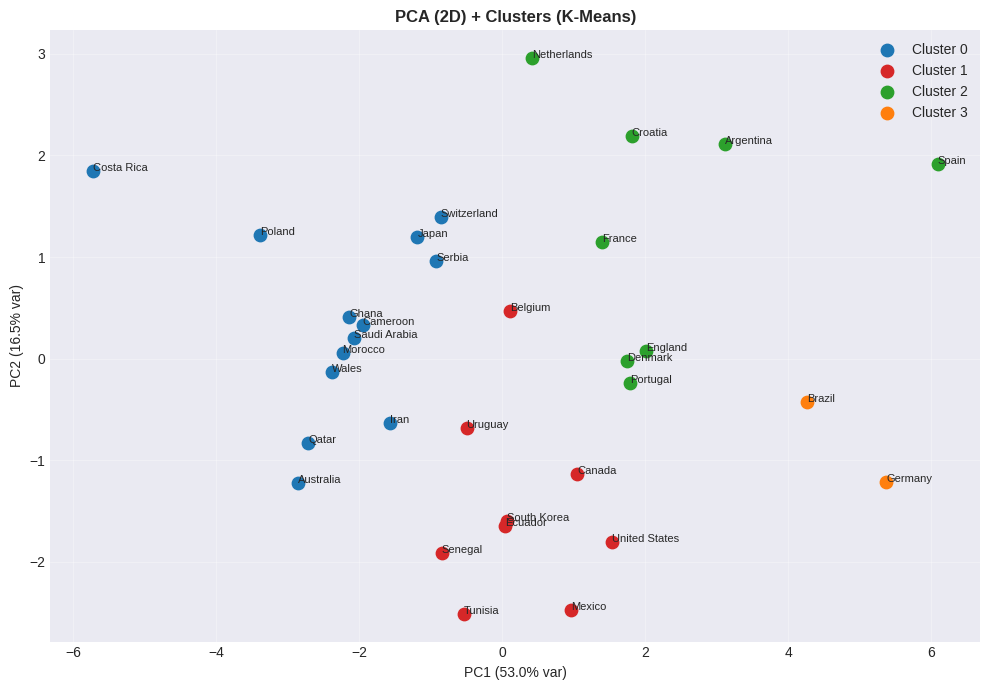

In [47]:
# =============================================================================
# PCA 2D
# =============================================================================
pca_2 = PCA(n_components=2, random_state=42)
X_pca_2 = pca_2.fit_transform(X_model)

pca_df = pd.DataFrame(X_pca_2, columns=["PC1", "PC2"], index=X_model.index)
pca_df["cluster"] = clusters_final

# 🎨 Diccionario de colores por cluster
cluster_colors = {
    0: "#1f77b4",  # azul
    1: "#d62728",  # rojo
    2: "#2ca02c",  # verde
    3: "#ff7f0e"   # naranja
}

plt.figure(figsize=(10, 7))

for cluster_id in sorted(pca_df["cluster"].unique()):
    subset = pca_df[pca_df["cluster"] == cluster_id]
    plt.scatter(
        subset["PC1"],
        subset["PC2"],
        color=cluster_colors[cluster_id],
        label=f"Cluster {cluster_id}",
        s=80
    )

plt.title("PCA (2D) + Clusters (K-Means)", fontweight="bold")
plt.xlabel(f"PC1 ({pca_2.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca_2.explained_variance_ratio_[1]*100:.1f}% var)")
plt.legend()
plt.grid(alpha=0.3)

# Etiquetas
for team, row in pca_df.iterrows():
    plt.text(row["PC1"], row["PC2"], team, fontsize=8)

plt.tight_layout()
plt.show()

 🔎 **Estructura general observada**

1️⃣ **Separación clara en el eje PC1**

El eje horizontal (PC1) parece actuar como dimensión principal de diferenciación entre estilos.

- Equipos situados a la derecha (ej. España, Alemania, Brasil) muestran un perfil claramente diferenciado.
- Equipos situados a la izquierda (ej. Costa Rica, Polonia, Qatar) presentan un patrón opuesto.

Esto sugiere que PC1 podría estar capturando una dimensión asociada a:
- Volumen ofensivo
- Control del juego
- Producción de xG y progresiones

---

2️⃣ Clusters compactos y coherentes

- El **Cluster 2 (verde)** agrupa equipos como España, Argentina, Croacia y Países Bajos, claramente diferenciados del resto.
- El **Cluster 1 (rojo)** aparece más aislado y compacto (ej. Alemania, Brasil), indicando un perfil específico.
- El **Cluster 3 (naranja)** agrupa equipos más próximos entre sí en la zona izquierda del gráfico.
- El **Cluster 0 (azul)** ocupa una zona intermedia, con mayor dispersión.

La estructura visual respalda los resultados obtenidos por las métricas internas (Silhouette y Davies-Bouldin).

---

3️⃣ Equipos extremos

Algunos equipos aparecen claramente alejados del centro:

- **España** (extremo derecho)
- **Costa Rica** (extremo izquierdo)
- **Alemania y Brasil** (zona inferior derecha)
- **Países Bajos** (zona superior)

Estos casos probablemente representan estilos más marcados o extremos dentro del torneo.

###🎨 Visualización 3D

In [49]:
# =============================================================================
# PCA 3D interactivo (Plotly) + nombres + colores correctos
# =============================================================================

# PCA 3 componentes
pca_3 = PCA(n_components=3, random_state=42)
X_pca_3 = pca_3.fit_transform(X_model)

pca_df = pd.DataFrame(
    X_pca_3,
    columns=["PC1", "PC2", "PC3"],
    index=X_model.index
).reset_index().rename(columns={"index": "team"})

# 🔑 IMPORTANTE: convertir cluster a string
pca_df["cluster"] = clusters_final.astype(str)

# Colores personalizados (claves deben ser string)
color_map = {
    "0": "#1f77b4",  # azul
    "1": "#d62728",  # rojo
    "2": "#2ca02c",  # verde
    "3": "#ff7f0e"   # naranja
}

fig = px.scatter_3d(
    pca_df,
    x="PC1",
    y="PC2",
    z="PC3",
    color="cluster",
    color_discrete_map=color_map,
    text="team",
    hover_name="team",
    title="PCA (3D) Interactivo + Clusters (K-Means)"
)

fig.update_traces(
    marker=dict(size=6),
    textposition="top center"
)

fig.update_layout(
    scene=dict(
        xaxis_title=f"PC1 ({pca_3.explained_variance_ratio_[0]*100:.1f}% var)",
        yaxis_title=f"PC2 ({pca_3.explained_variance_ratio_[1]*100:.1f}% var)",
        zaxis_title=f"PC3 ({pca_3.explained_variance_ratio_[2]*100:.1f}% var)",
    ),
    legend_title_text="Cluster",
    margin=dict(l=0, r=0, b=0, t=50)
)

fig.show()

 🔎 **Estructura general observada**

La proyección en 3 dimensiones (PC1, PC2 y PC3) permite capturar una mayor proporción de la varianza total del dataset, reduciendo parte del solapamiento observado en 2D.

En este espacio:

- Se aprecia mejor la separación entre algunos equipos que en 2D parecían próximos.
- PC3 (≈17% de varianza) añade una dimensión adicional de diferenciación táctica.
- Los clusters mantienen coherencia estructural, confirmando que la segmentación no es un artefacto de la reducción bidimensional.

La visualización 3D refuerza la validez del clustering y confirma la existencia de perfiles diferenciados de juego en el torneo.


## Perfilado e Interpretación de Clusters

Una vez validada la calidad del clustering y visualizada su estructura,
la etapa clave consiste en interpretar qué representa cada grupo.

El objetivo no es solo separar equipos estadísticamente,
sino identificar **arquetipos tácticos diferenciados**.

Para ello:

1. Analizamos las métricas promedio por cluster en escala original.
2. Comparamos cada cluster respecto a la media global.
3. Identificamos qué variables distinguen a cada grupo.
4. Asignamos una etiqueta táctica interpretativa.


In [50]:
# =============================================================================
# PERFILADO DE CLUSTERS EN MÉTRICAS ORIGINALES
# =============================================================================

# Dataset base: métricas reales por equipo
df_eval = df_teams.copy()
df_eval = df_eval.set_index("team")

# Añadir cluster final
df_eval["cluster"] = clusters_final

# Métricas utilizadas en el modelo
profile_cols = feature_cols

# Promedios por cluster
cluster_profile = df_eval.groupby("cluster")[profile_cols].mean().round(3)

print("=" * 80)
print("PERFIL PROMEDIO POR CLUSTER (VALORES REALES)")
print("=" * 80)

display(cluster_profile)

# Media global
global_mean = df_eval[profile_cols].mean().round(3)

print("\nMEDIA GLOBAL DEL TORNEO:")
display(global_mean)


PERFIL PROMEDIO POR CLUSTER (VALORES REALES)


,xg_per_90,shots_per_90,xg_per_shot,passes_into_box_per_90,passes_per_90,progressions_per_90,final_third_entries_per_90,xga_per_90,shots_against_per_90,ppda_approx,recoveries_opp_half_per_90,off_actions_per_min
cluster,,,,,,,,,,,,
0,1.023,8.661,0.115,26.016,427.394,190.957,58.989,1.749,14.700,8.537,16.711,8.380
1,1.075,11.630,0.093,34.407,502.000,212.194,69.278,1.065,9.639,9.000,22.269,10.063
2,1.856,12.888,0.144,37.771,670.017,251.104,81.506,1.517,10.833,8.370,19.021,13.629
3,2.736,21.233,0.129,50.800,646.767,245.400,83.933,0.982,8.233,10.763,27.100,13.129



MEDIA GLOBAL DEL TORNEO:


,0
xg_per_90,1.353
shots_per_90,11.338
xg_per_shot,0.117
passes_into_box_per_90,32.864
passes_per_90,522.743
progressions_per_90,215.369
final_third_entries_per_90,69.071
xga_per_90,1.451
shots_against_per_90,11.906
ppda_approx,8.765


## 🎯 Interpretación Táctica de los Clusters

A partir de los promedios reales por cluster y su comparación con la media global del torneo, se identifican cuatro arquetipos diferenciados de estilo de juego.

---

### 🔵 Cluster 0 — Perfil Reactivo / Bajo Volumen Ofensivo

**Equipos incluidos:** Australia, Camerún, Costa Rica, Ghana, Irán, Japón, Marruecos, Polonia, Qatar, Arabia Saudí, Serbia, Suiza, Gales.

**Características principales:**

- xG/90 (1.02) ↓ por debajo de la media
- Tiros/90 (8.66) ↓ claramente inferior
- Pases/90 (427) ↓ bajo control de balón
- xGA/90 (1.75) ↑ concede más peligro del promedio
- Ritmo ofensivo bajo (8.38 acciones/min)

**Interpretación:**

Equipos con menor volumen ofensivo y menor control del juego.  
Tienden a conceder más ocasiones y generar menos amenaza sostenida.

Este perfil encaja con selecciones que compitieron desde el orden defensivo o el bloque medio-bajo, como Costa Rica, Irán o Arabia Saudí.  
Incluso Marruecos, pese a su éxito competitivo, se apoyó en una estructura defensiva sólida y menor volumen ofensivo.

---

### 🔴 Cluster 1 — Perfil Equilibrado / Competitivo

**Equipos incluidos:** Bélgica, Canadá, Ecuador, México, Senegal, Corea del Sur, Túnez, Estados Unidos, Uruguay.

**Características principales:**

- Métricas cercanas a la media
- Buen balance ataque-defensa
- xGA/90 (1.06) ↓ solidez defensiva
- Recuperaciones en campo rival (22.3) ↑ presión activa

**Interpretación:**

Equipos equilibrados y físicamente competitivos.  
No dominan territorialmente de forma estructural, pero tampoco se repliegan de manera constante.

Selecciones como Estados Unidos, Senegal o Canadá encajan bien en este perfil: intensidad, transición y presión activa, sin un dominio posicional prolongado.

---

### 🟢 Cluster 2 — Control Alto / Juego Elaborado

**Equipos incluidos:** Argentina, Croacia, Dinamarca, Inglaterra, Francia, Países Bajos, Portugal, España.

**Características principales:**

- Pases/90 (670) ↑ muy por encima de la media
- Progresiones/90 (251) ↑
- Entradas al último tercio (81.5) ↑
- xG/90 (1.86) ↑
- Ritmo alto (13.63 acciones/min)

**Interpretación:**

Equipos con fuerte control territorial y circulación elevada.  
Se instalan con frecuencia en campo rival y generan amenaza de forma sostenida.

Este cluster agrupa a la mayoría de selecciones consideradas estructuralmente dominantes del torneo, como España, Argentina o Francia.

---

### 🟠 Cluster 3 — Dominancia Ofensiva Extrema

**Equipos incluidos:** Brasil y Alemania.

**Características principales:**

- xG/90 (2.74) ↑↑ extremadamente alto
- Tiros/90 (21.23) ↑↑ volumen ofensivo muy elevado
- Pases al área (50.8) ↑ máximo del torneo
- xGA/90 (0.98) ↓ sólida defensa
- Recuperaciones en campo rival (27.1) ↑ presión alta

**Interpretación:**

Equipos con producción ofensiva excepcional y presión intensa.  
Generan un volumen muy superior al resto del torneo.

Brasil y Alemania aparecen como outliers estadísticos en términos ofensivos, lo que explica su separación en un cluster propio.

---

## 🧠 Conclusión General

El clustering identifica una gradación clara de estilos en el Mundial 2022:

1. Reactivos y de bajo volumen
2. Equilibrados e intensos
3. Dominantes estructurales
4. Dominancia ofensiva extrema

La segmentación no responde a resultados finales, sino a patrones estructurales de juego medidos objetivamente, lo que refuerza la validez del enfoque basado en Machine Learning no supervisado.


## ⚠️ Limitaciones del Análisis

Aunque el modelo identifica patrones estructurales coherentes, es importante contextualizar los resultados dentro del entorno específico del Mundial 2022.

### 1️⃣ Tamaño de muestra reducido

El Mundial es una competición corta (entre 3 y 7 partidos por selección).  
Esto implica que:

- Las métricas pueden verse influenciadas por pocos eventos.
- Un partido atípico puede afectar significativamente los promedios.
- No necesariamente reflejan el estilo estructural a largo plazo del equipo.

---

### 2️⃣ Dependencia del rival

Las métricas colectivas dependen en gran medida del tipo de oponente enfrentado.

Por ejemplo:
- Un equipo puede registrar bajo volumen ofensivo frente a un rival dominante.
- Otro puede inflar métricas ante selecciones de menor nivel.

El clustering captura comportamiento observado en el torneo, no necesariamente el estilo “intrínseco” independiente del contexto.

---

### 3️⃣ Contexto competitivo (fase de grupos vs eliminatorias)

En fases eliminatorias, los equipos pueden modificar su planteamiento:
- Mayor cautela defensiva
- Menor exposición al riesgo
- Gestión estratégica del marcador

Por tanto, el modelo identifica estilos dentro del contexto competitivo del Mundial, no un perfil absoluto independiente del torneo.

---

### 4️⃣ Número desigual de partidos jugados

Las selecciones que alcanzaron fases avanzadas disputaron más encuentros, lo que puede aportar mayor estabilidad estadística respecto a equipos eliminados en fase de grupos.

---



# 🏁 Conclusión Final — Respuesta al Business Understanding

## ¿Se logró el objetivo del proyecto?

Sí.

El objetivo inicial consistía en desarrollar un sistema de segmentación de selecciones del Mundial 2022 mediante técnicas de Machine Learning no supervisado, con el fin de identificar estilos de juego de forma objetiva y reproducible.

A través del uso de clustering (K-Means optimizado y reducción dimensional con PCA), se logró:

- Agrupar las 32 selecciones en **4 perfiles estructurales diferenciados**
- Identificar patrones consistentes en producción ofensiva, control territorial, intensidad defensiva y ritmo de juego
- Obtener clusters interpretables y coherentes desde el punto de vista futbolístico

---

## ¿Existen estilos de juego diferenciados en el Mundial 2022?

Sí.

El modelo identificó cuatro grandes arquetipos:

1. Equipos reactivos y de bajo volumen ofensivo  
2. Equipos equilibrados e intensos  
3. Equipos dominantes en control y construcción elaborada  
4. Equipos de dominancia ofensiva extrema  

Estos grupos no se basan en percepción subjetiva, sino en métricas agregadas de rendimiento derivadas de datos de eventos.

---

## 🎯 Conclusión General

El análisis demuestra que es posible identificar estilos de juego diferenciados de manera objetiva utilizando datos de eventos y técnicas de Machine Learning no supervisado.

Sin embargo, los resultados deben interpretarse como:

> Caracterización de comportamiento competitivo en torneo corto y no como una definición definitiva del estilo estructural permanente de cada selección.

En consecuencia, el proyecto cumple el objetivo planteado en la fase de Business Understanding y valida el uso del clustering como herramienta útil para el análisis táctico colectivo en competiciones internacionales.

Futuras extensiones podrían incluir:
- Datos de múltiples competiciones
- Datos de clasificación
- Ventanas temporales más amplias
